# Importing packages

In [122]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [123]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [124]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [125]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "DescFits_1b_red025_rand65_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250513_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_descFits_1b_red025_rand65_", 
                                     folderName_common= "250513_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [126]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [127]:
#parameters of SVM 
red_factor = 0.25

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

# rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.75, 0.9, 1]
rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]


#random seed 
randomSeed = 65

# importing our data

In [128]:
dataFileName = "DF_SVM_DescFits__20250410_v2.xlsx"

In [129]:
# "C:\Users\mcremer\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_20250410_v2\DF_SVM_DescFits__20250410_v2.xlsx"

In [130]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

# #need to drop down to the 17 features found in the initial run of feature reduction 0.25
# #best to do this with a columns to keep situation
# x_columns_toKeep = ["age", "BUN_25%", "BUN_50%", "Chloride_50%", "Glucose_min", "Hemoglobin_max",
#                     "Platelet Count_max", "Sodium_max", "NT Pro BNP_50%", "Chloride_linear_r2",
#                     "Total Serum Protein_linear_intercept", "Troponin-T_linear_r2",
#                     "Chloride_exp_r2", "LDH_exp_mse", "Serum Electrophoresis Alpha 2_exp_intercept",
#                     "Total Serum Protein_exp_intercept", "Troponin-T_exp_r2"]


#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

# #keeping only the columns of interest
# X = X[x_columns_toKeep]

In [131]:
x_drop_exp_intercepts = [feature for feature in list(dataTable.columns) if "_exp_intercept" in feature]

#dropping the intercepts
X.drop(columns = x_drop_exp_intercepts, inplace = True)

In [132]:
binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

sex_female  dx_mgus  dx_mm  HematologicTx  RadiationTx  OtherTx  \
0            0        1      0              0            0        0   
1            1        0      1              0            0        0   
2            0        1      0              0            0        0   
3            0        1      0              0            0        0   
4            0        0      1              1            0        0   
5            1        0      1              0            0        0   
6            1        0      1              0            0        0   
7            0        1      0              0            0        0   
8            1        0      1              0            0        0   
9            1        0      1              0            0        0   
10           0        1      0              0            0        0   
11           0        0      1              0            0        0   
12           1        0      1              0            0        0   
13           0        1      0              0            0        0   
14           1        0      1              0            0        0   
15           0        0      0              0            0        0   
16           0        0      1              0            0        0   
17           0        0      1              0            0        0   
18           0        1      0              0            0        0   
19           0        1      0              0            0        0   
20           1        1      0              0            0        0   
21           1        1      0              0            0        0   
22           0        0      1              0            0        0   
23           1        0      0              0            0        0   
24           0        0      1              1            0        0   
25           0        1      0              0            0        0   
26           0        0      1              1            0        0   
27           1        1      0              0            0        0   
28           0        1      0              0            0        0   
29           0        0      1              1            1        0   
30           0        0      1              0            0        0   
31           0        0      0              0            0        2   
32           0        0      1              0            0        0   
33           0        0      1              0            0        0   
34           1        0      1              1            0        0   
35           1        1      0              0            0        0   
36           0        0      1              1            0        0   
37           1        1      0              0            0        0   
38           1        0      1              0            0        0   
39           0        0      1              1            0        0   
40           1        0      1              1            0        0   
41           0        1      0              0            0        0   
42           0        0      1              0            0        0   
43           1        0      0              0            0        0   

    ChemoTx_True  HematologicTx_True  RadiationTx_True  ImmunoTx_True  \
0              0                   0                 0              0   
1              1                   0                 0              0   
2              0                   0                 0              0   
3              0                   0                 0              0   
4              1                   1                 0              0   
5              0                   0                 0              0   
6              1                   0                 0              1   
7              0                   0                 0              0   
8              1                   0                 0              1   
9              1                   0                 0              0   
10   

# Setting up classifier

## Scaling data and defining test set

In [133]:
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= randomSeed, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

1.260252075625209

In [134]:
whatTrainPatients = [dataTable.loc[index, 'DeID'] for index in list(y_train.index)]
whatTestPatients = [dataTable.loc[index, 'DeID'] for index in list(y_test.index)]
print(randomSeed)
if 'T-01' in whatTrainPatients:
    print ("T-01 in training set")

65
T-01 in training set


In [135]:
# whatTrainPatients
whatTestPatients

['B-02', 'H-02', 'N-03', 'Q-01', 'H-01', 'Y-01', 'E-02', 'E-01', 'G-03']

In [136]:
outputToExcel(df_data=dataTable.loc[list(y_train.index)], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "train_data")
outputToExcel(df_data=dataTable.loc[list(y_test.index)], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "test_data")

## define cross validation

In [137]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [138]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.6742857142857143,
 'auc': 0.7555555555555555,
 'score': 0.714920634920635,
 'C': 0.0078125}

In [139]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.8,
 'auc': 0.9,
 'true neg': 3,
 'false pos': 2,
 'false neg': 0,
 'true pos': 4,
 'precision or PPV': 0.6666666666666666,
 'recall or TPR': 1.0,
 'specificity or TNR': 0.6}

# alternative models

In [140]:
# alternative models

In [141]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [142]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

ROC:  0.7750000000000001
F1:  0.75


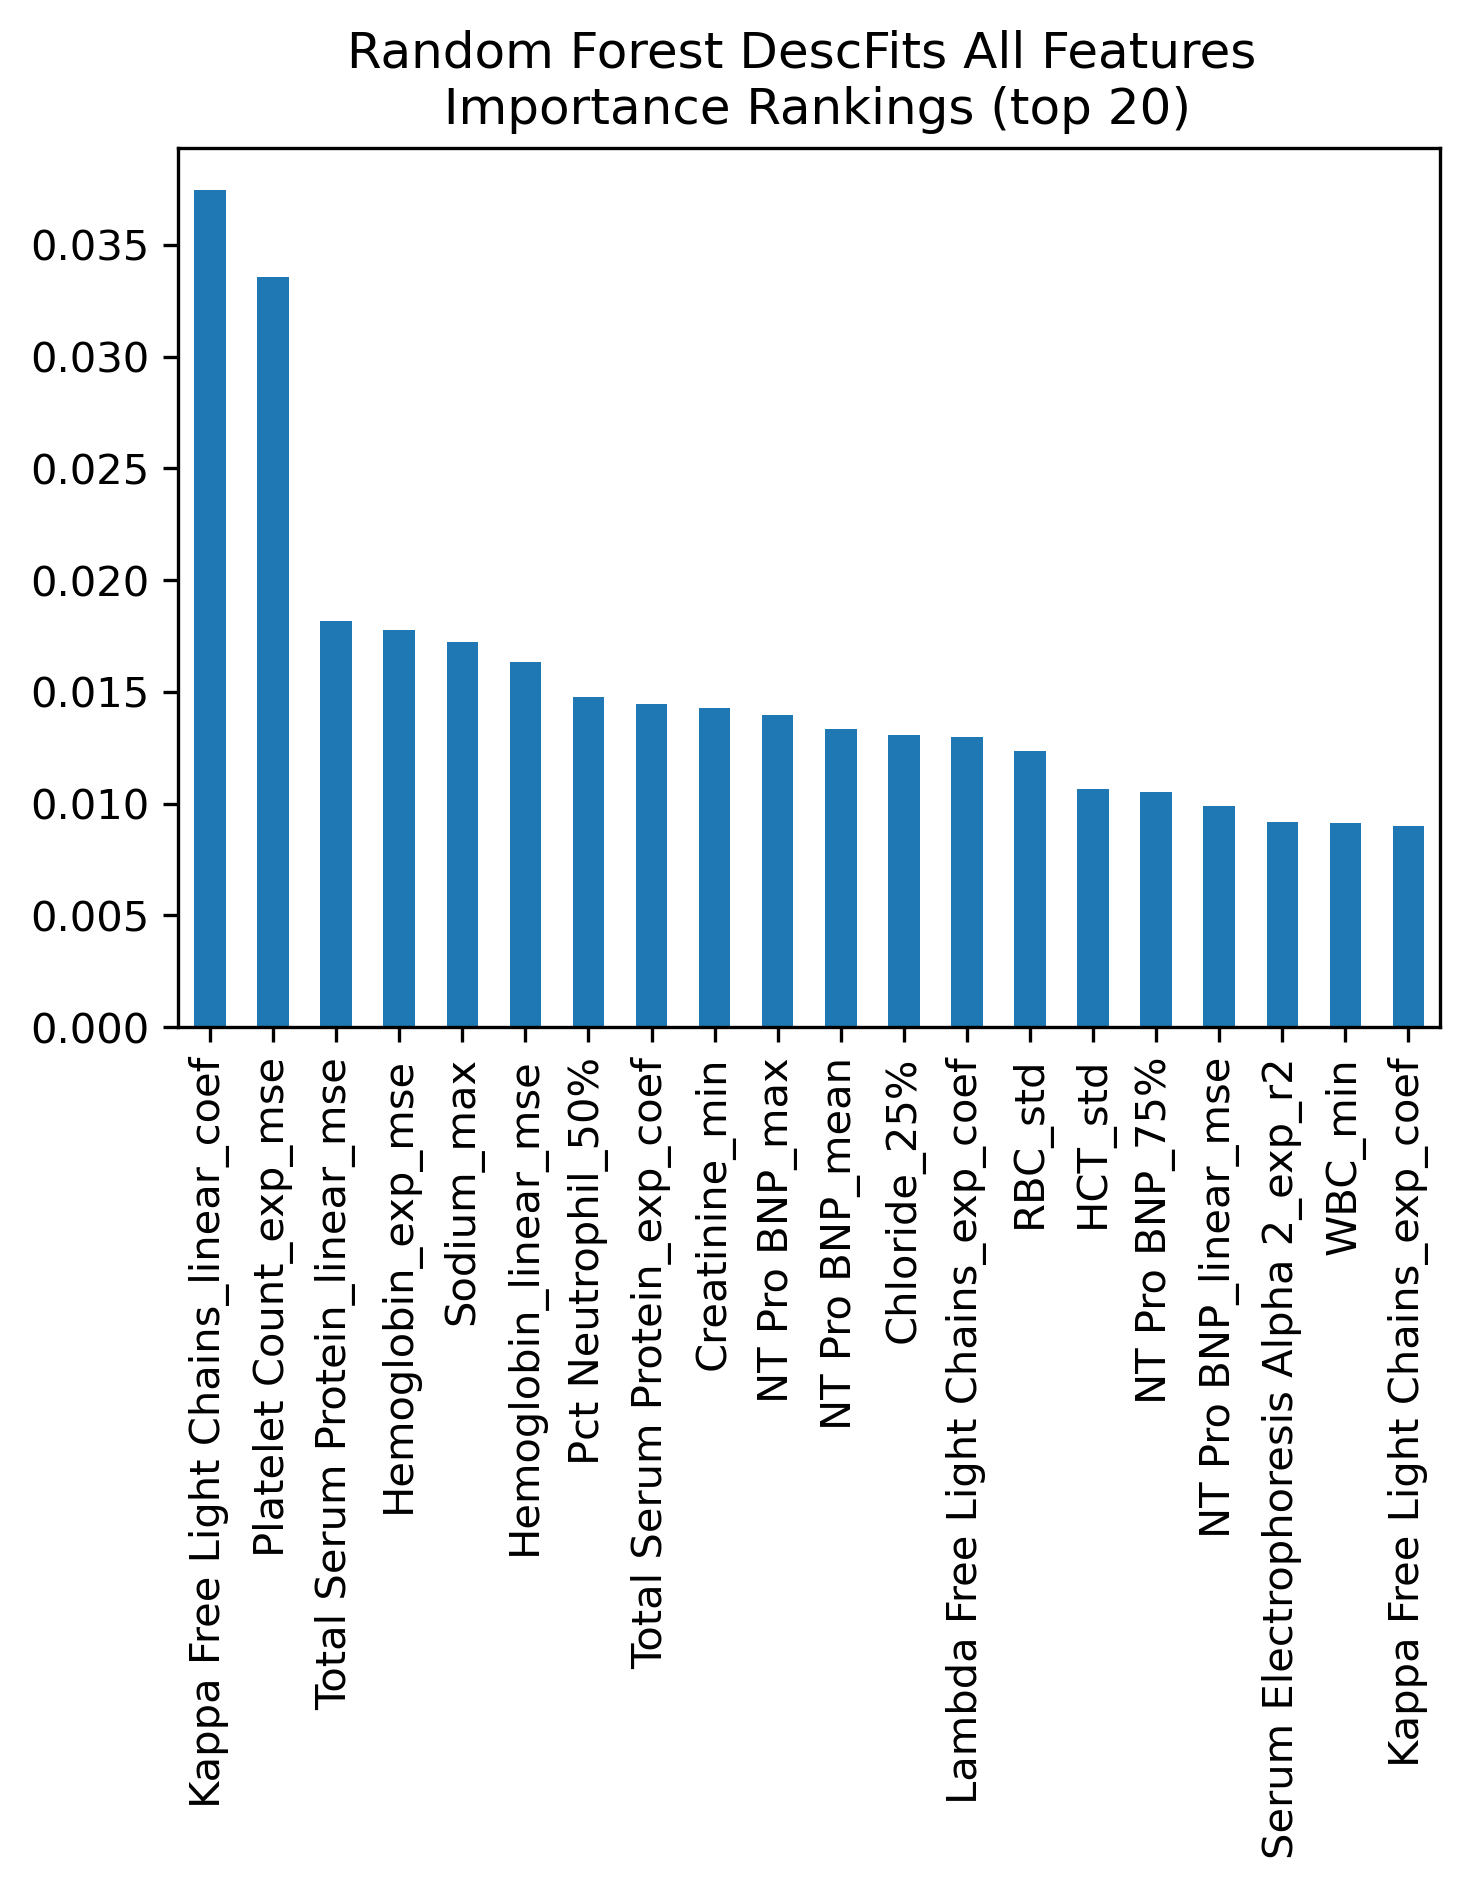

In [143]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest DescFits All Features \n Importance Rankings (top 20)")

# Show the plot
plt.show()

In [144]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [145]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(what_train[list(top_20_importances.index[:5])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:5])])
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:5])].columns)

ROC:  0.425
F1:  0.2857142857142857


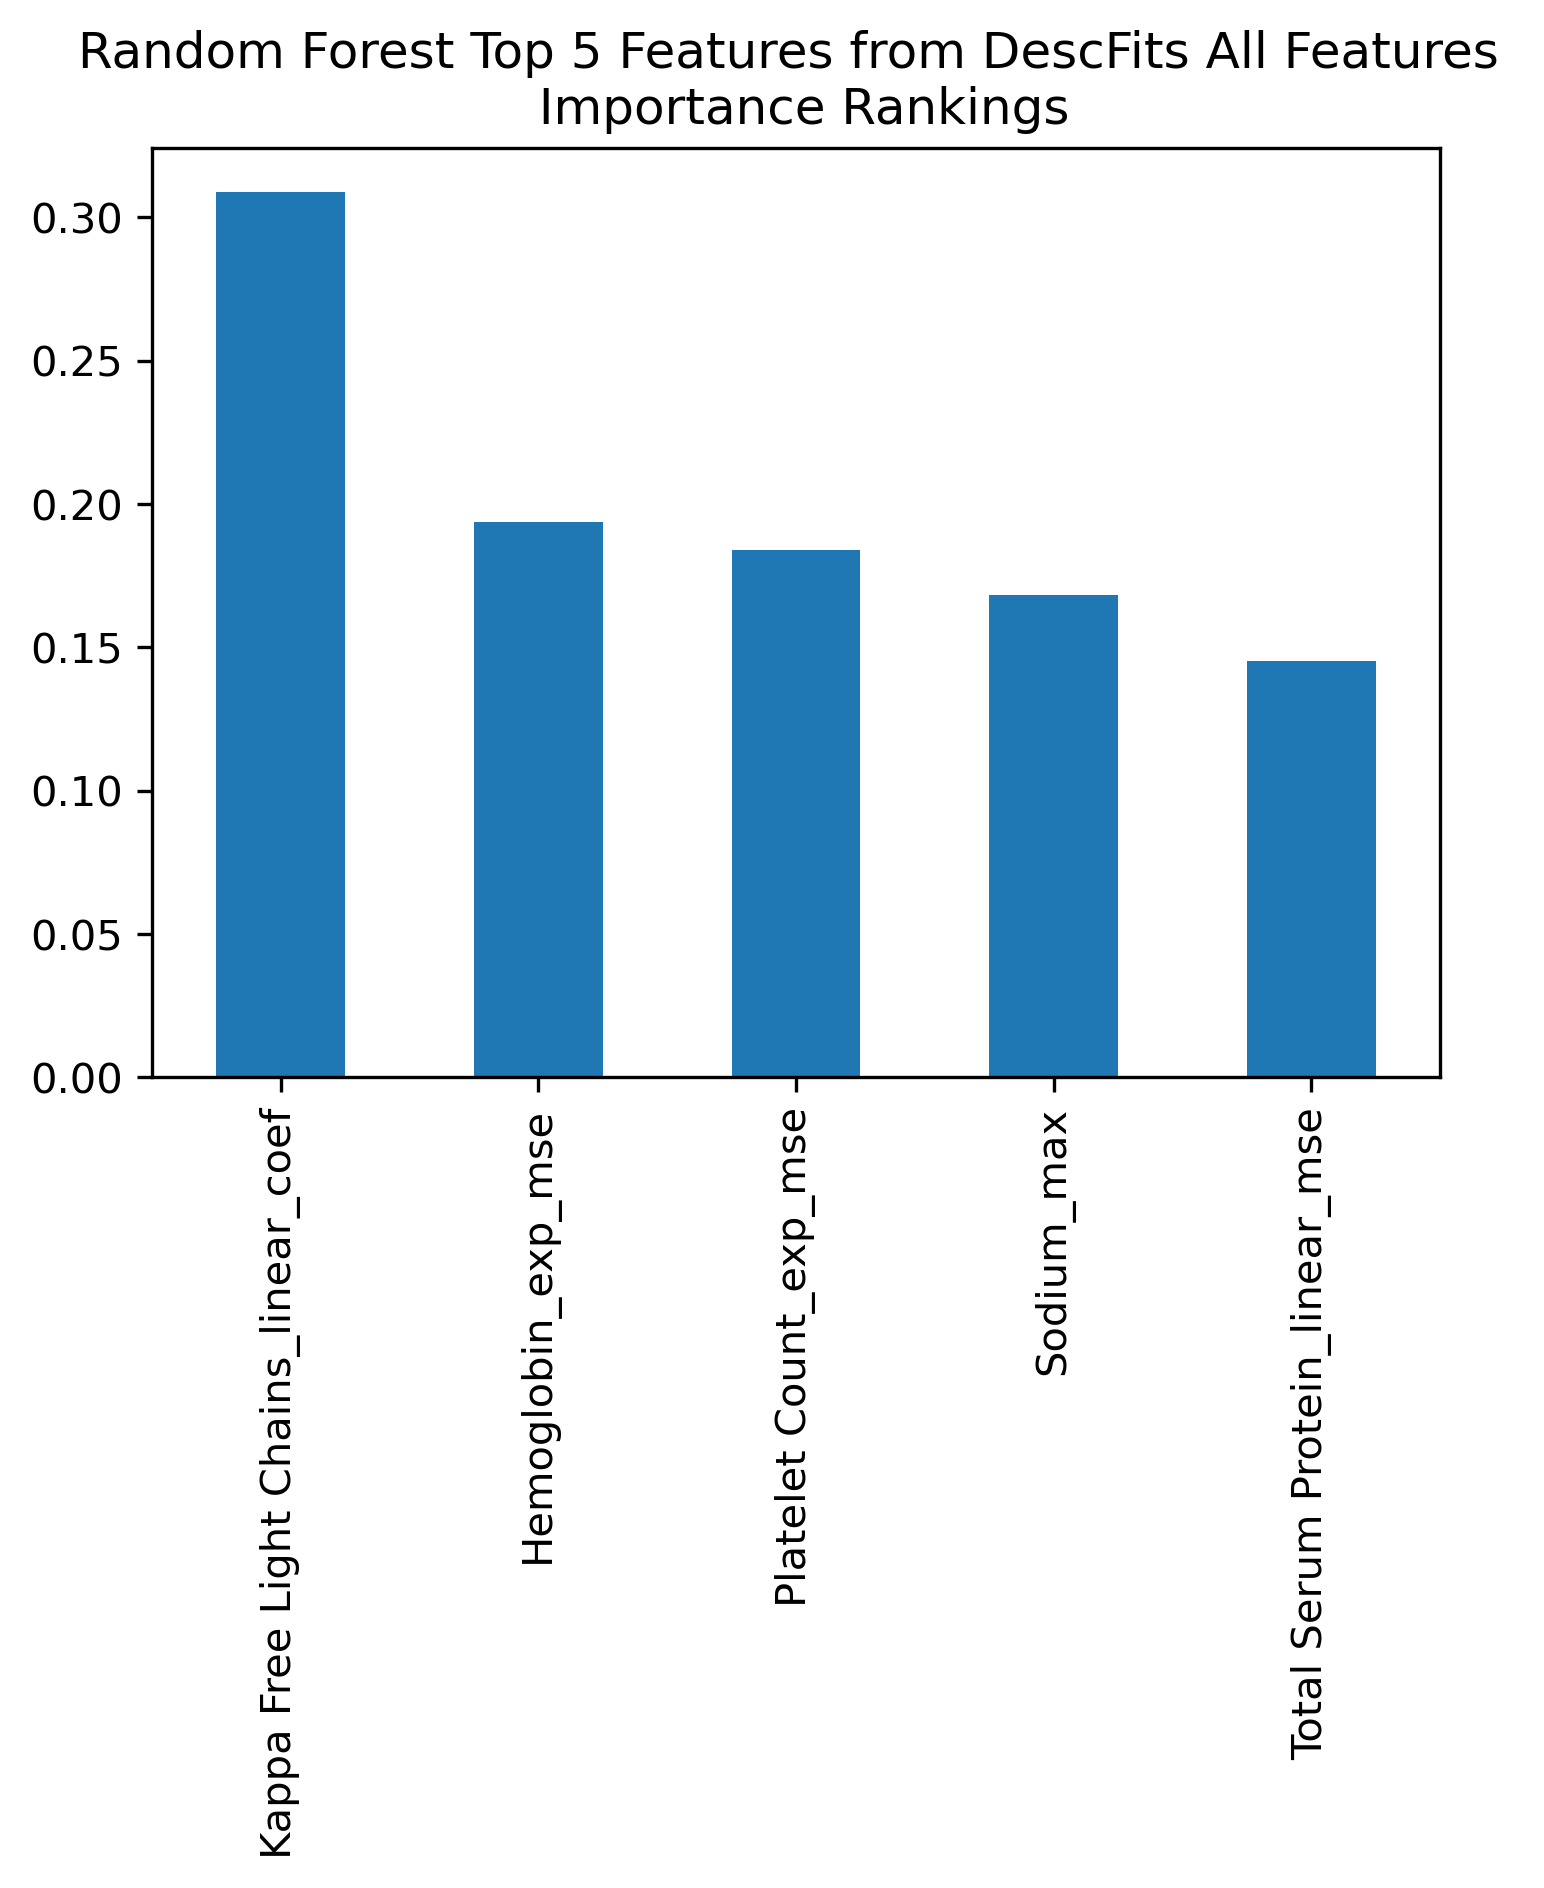

In [146]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 5 Features from DescFits All Features \n Importance Rankings")

# Show the plot
plt.show()

In [147]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

ROC:  0.7750000000000001
F1:  0.75


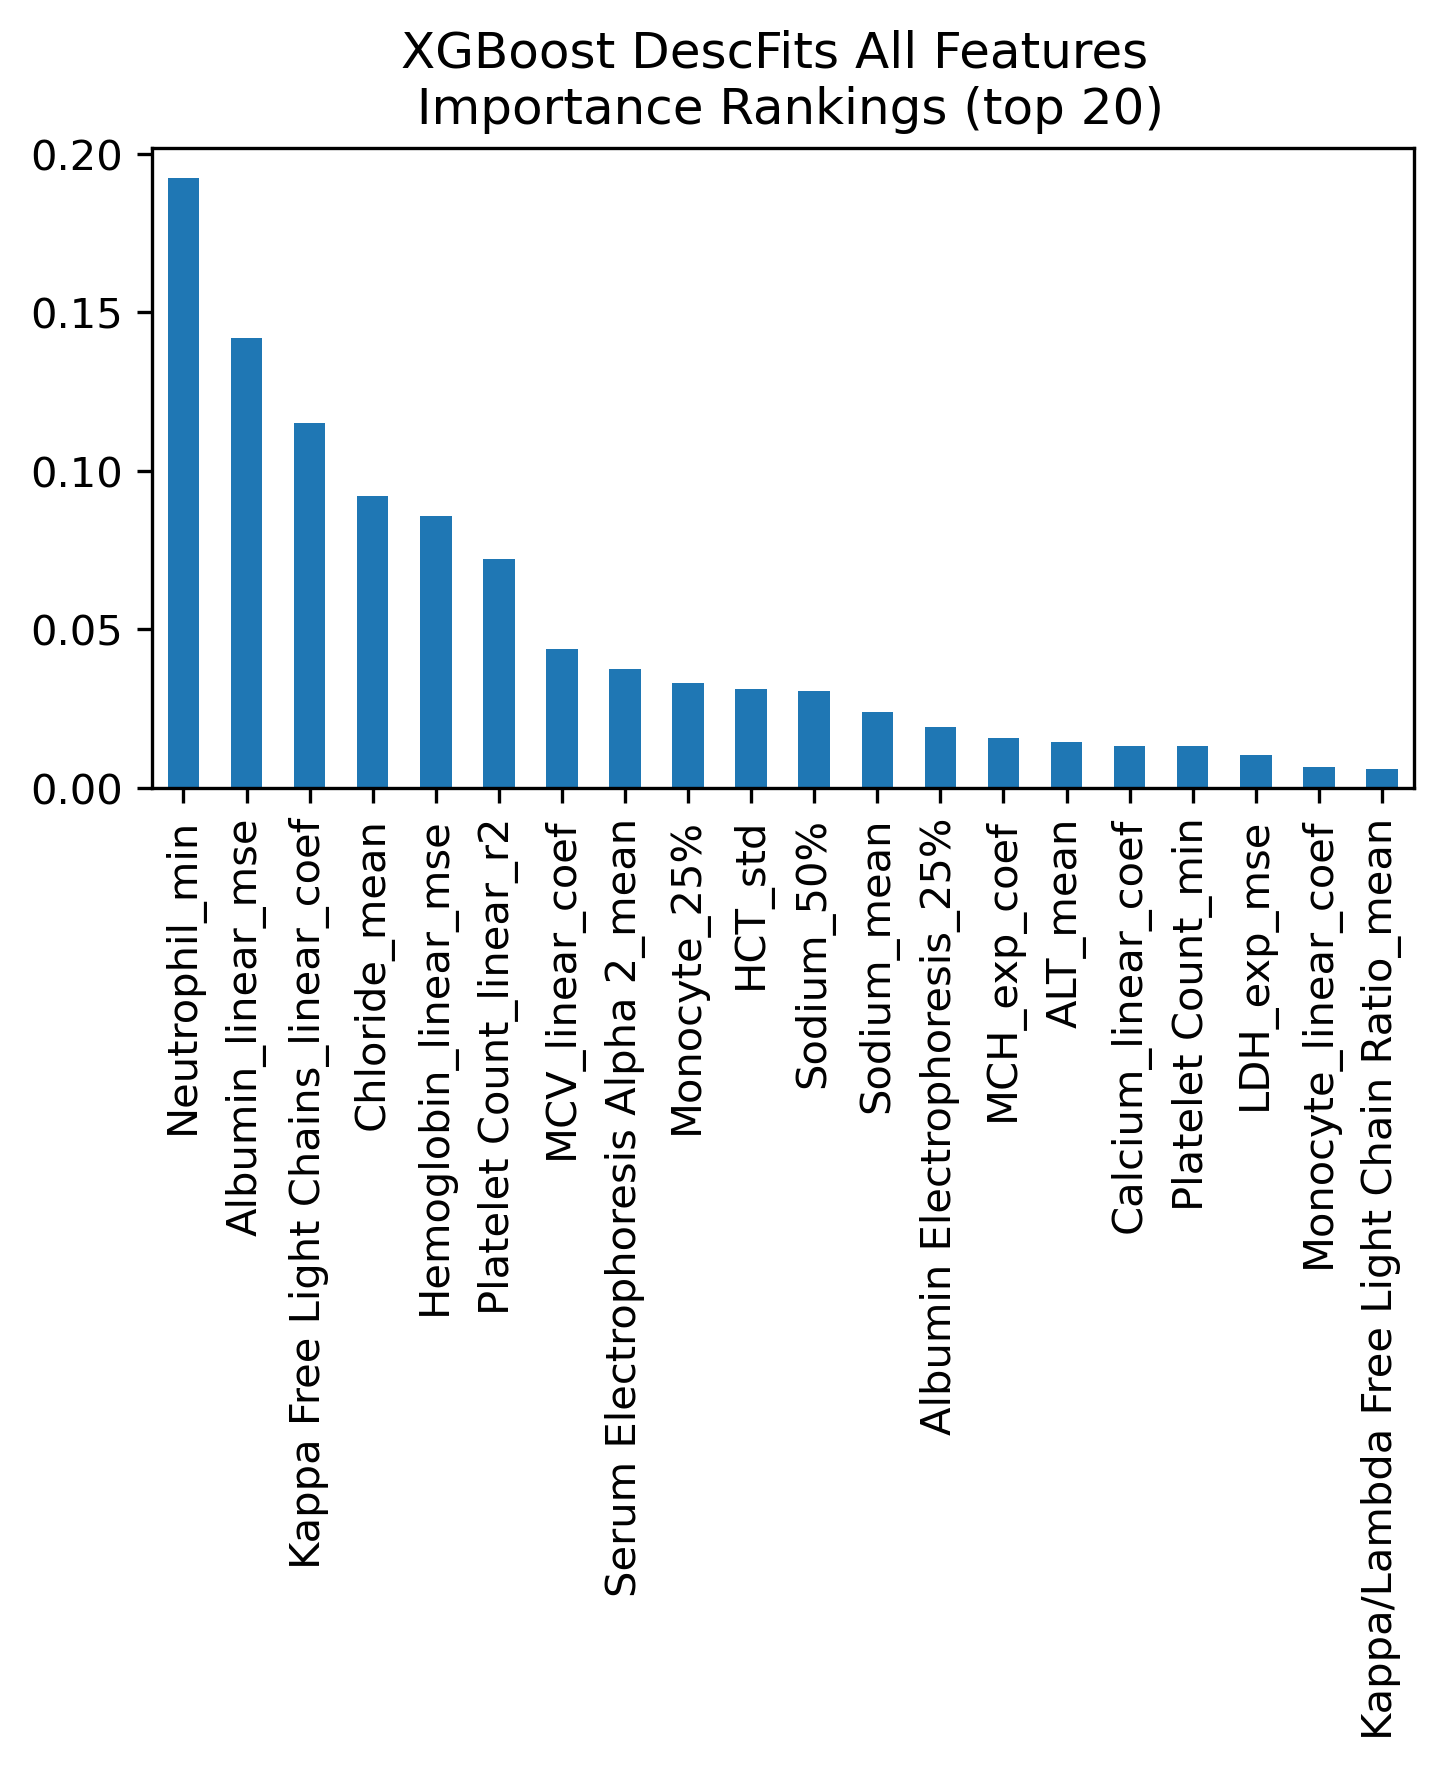

In [148]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost DescFits All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [149]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7058
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 586
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



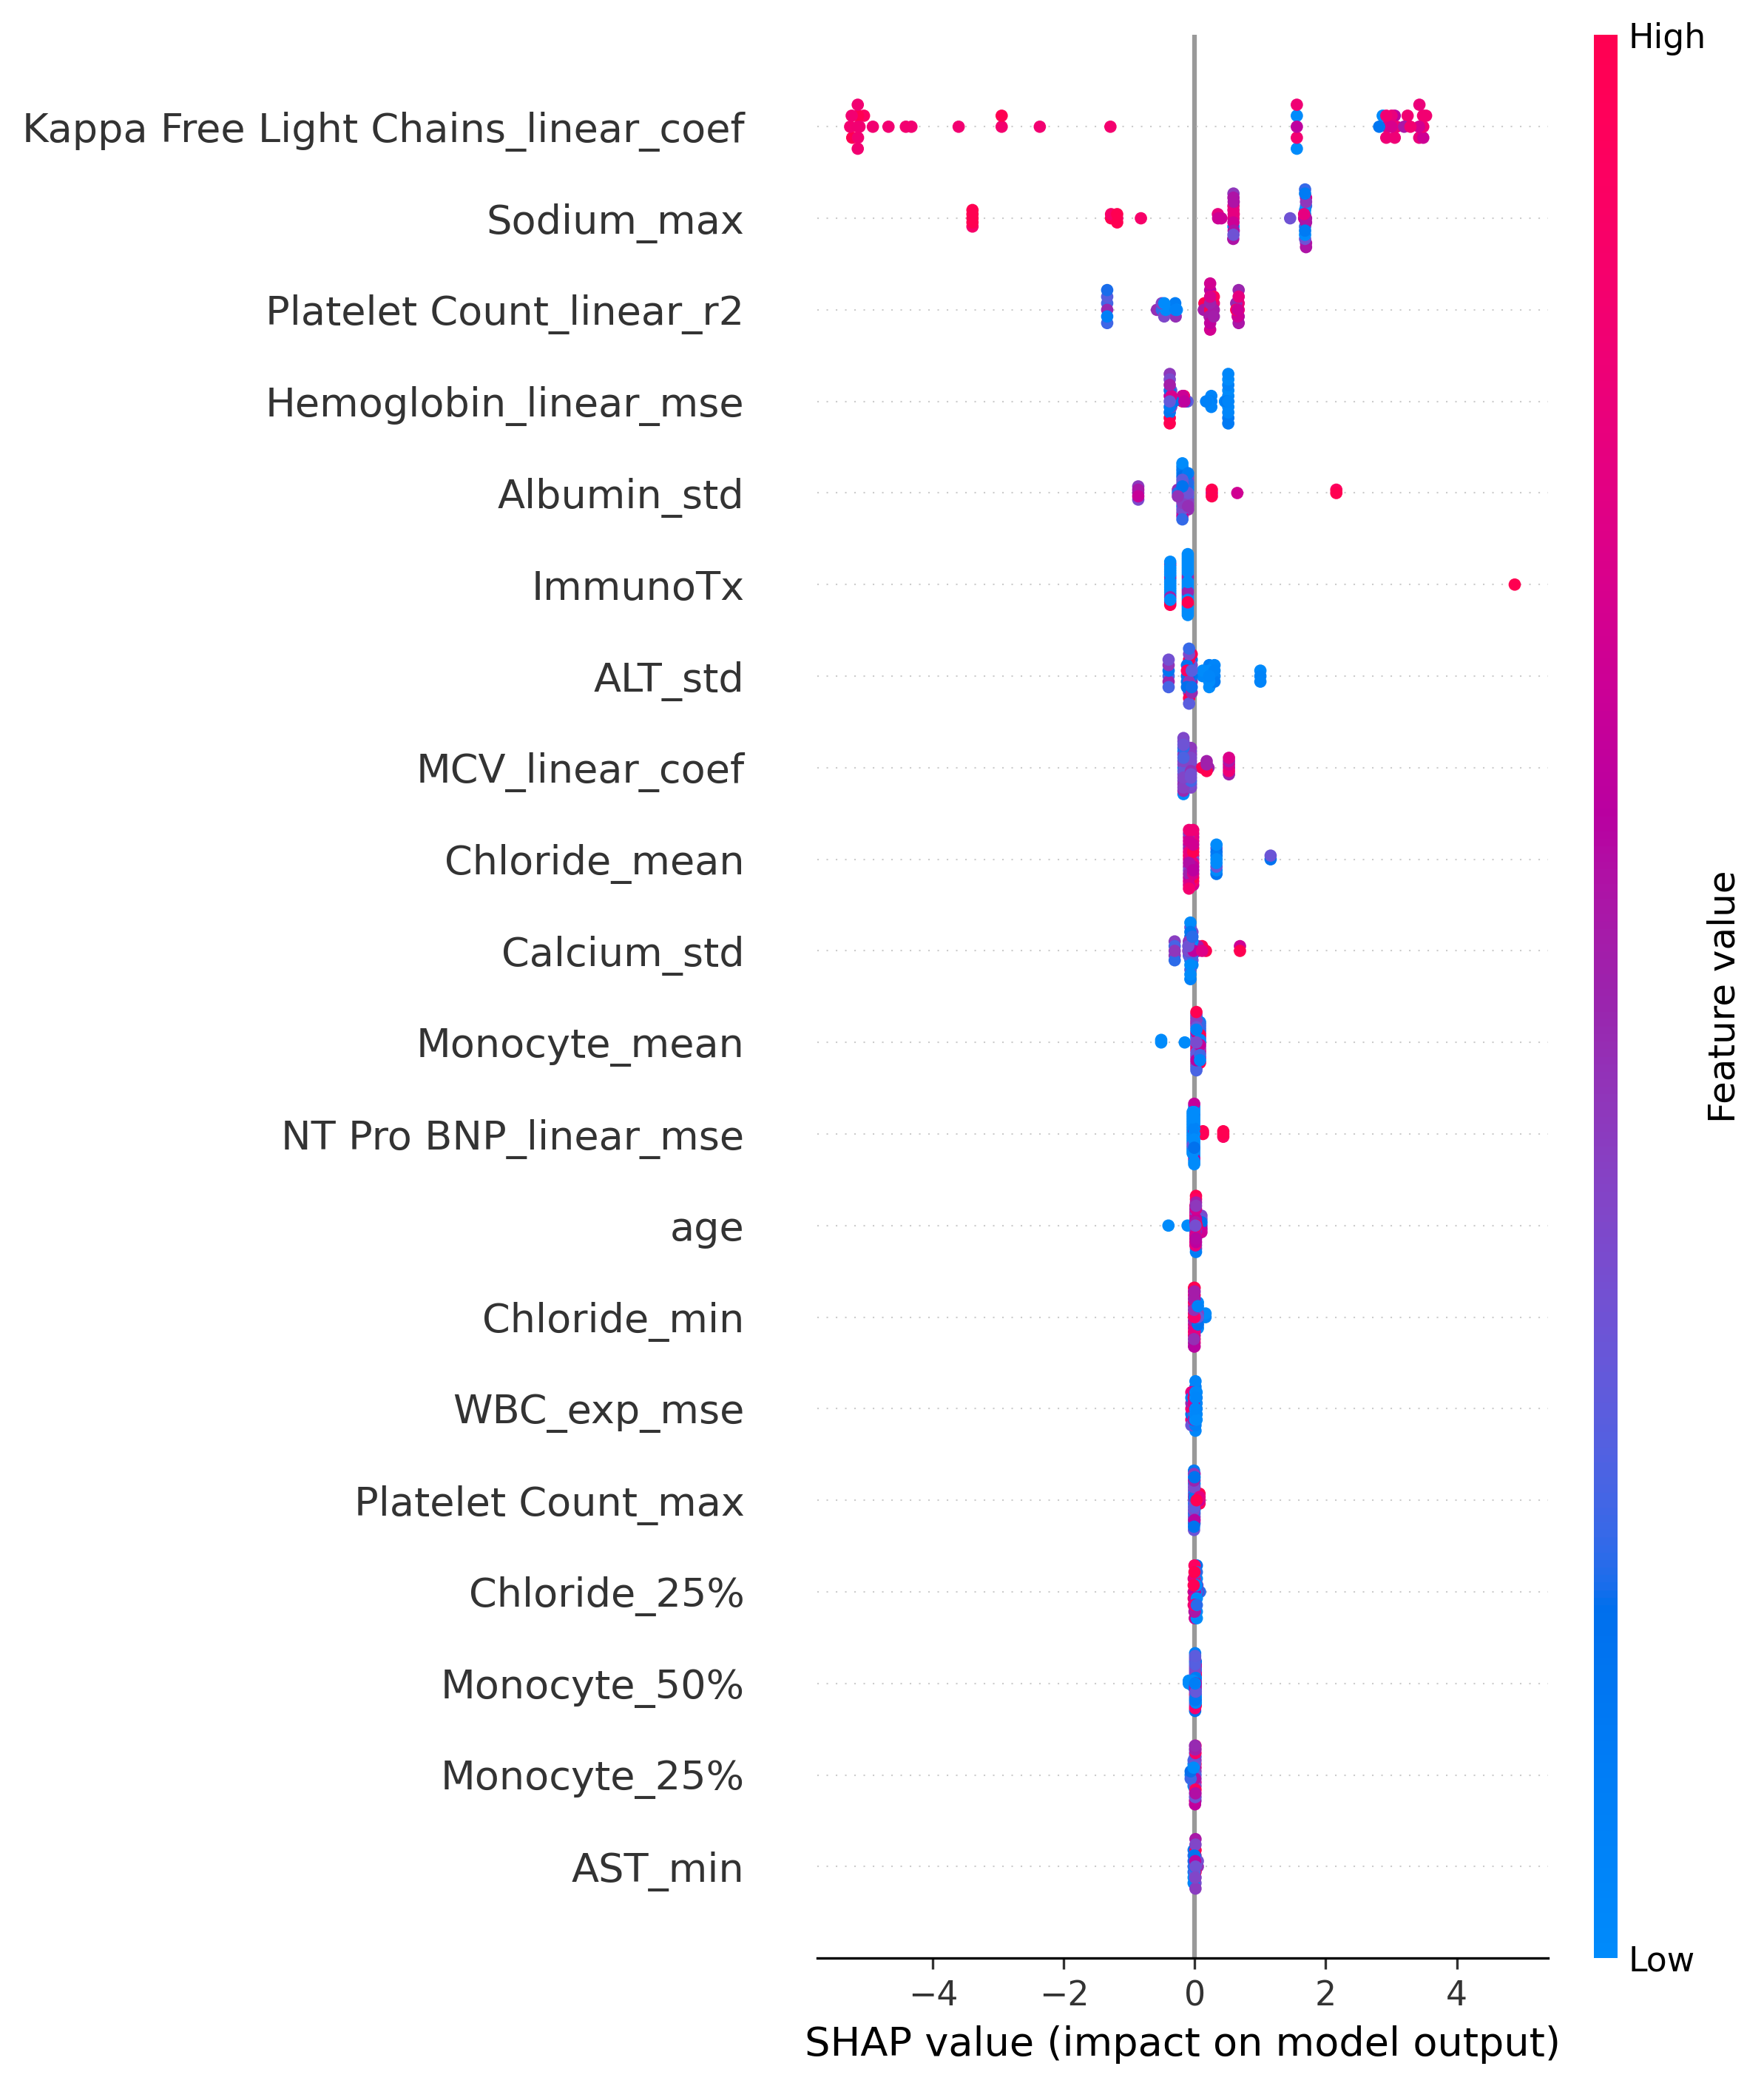

In [150]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [151]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 589, Score: 0.715
Number of Features: 441, Score: 0.735
Number of Features: 330, Score: 0.784
Number of Features: 247, Score: 0.786
Number of Features: 185, Score: 0.851
Number of Features: 138, Score: 0.782
Number of Features: 103, Score: 0.713
Number of Features: 77, Score: 0.695
Number of Features: 57, Score: 0.744
Number of Features: 42, Score: 0.674
Number of Features: 31, Score: 0.674
Number of Features: 23, Score: 0.758
Number of Features: 17, Score: 0.757
Number of Features: 12, Score: 0.749
Number of Features: 8, Score: 0.752
Number of Features: 5, Score: 0.849
Number of Features: 3, Score: 0.879
Number of Features: 2, Score: 0.873
Number of Features: 1, Score: 0.522
Rank weight: 0.15
Number of Features: 589, Score: 0.715
Number of Features: 441, Score: 0.704
Number of Features: 330, Score: 0.721
Number of Features: 247, Score: 0.780
Number of Features: 185, Score: 0.782
Number of Features: 138, Score: 0.876
Number of Features: 103, Score:

# Performance plots

## F1 and AUC plots

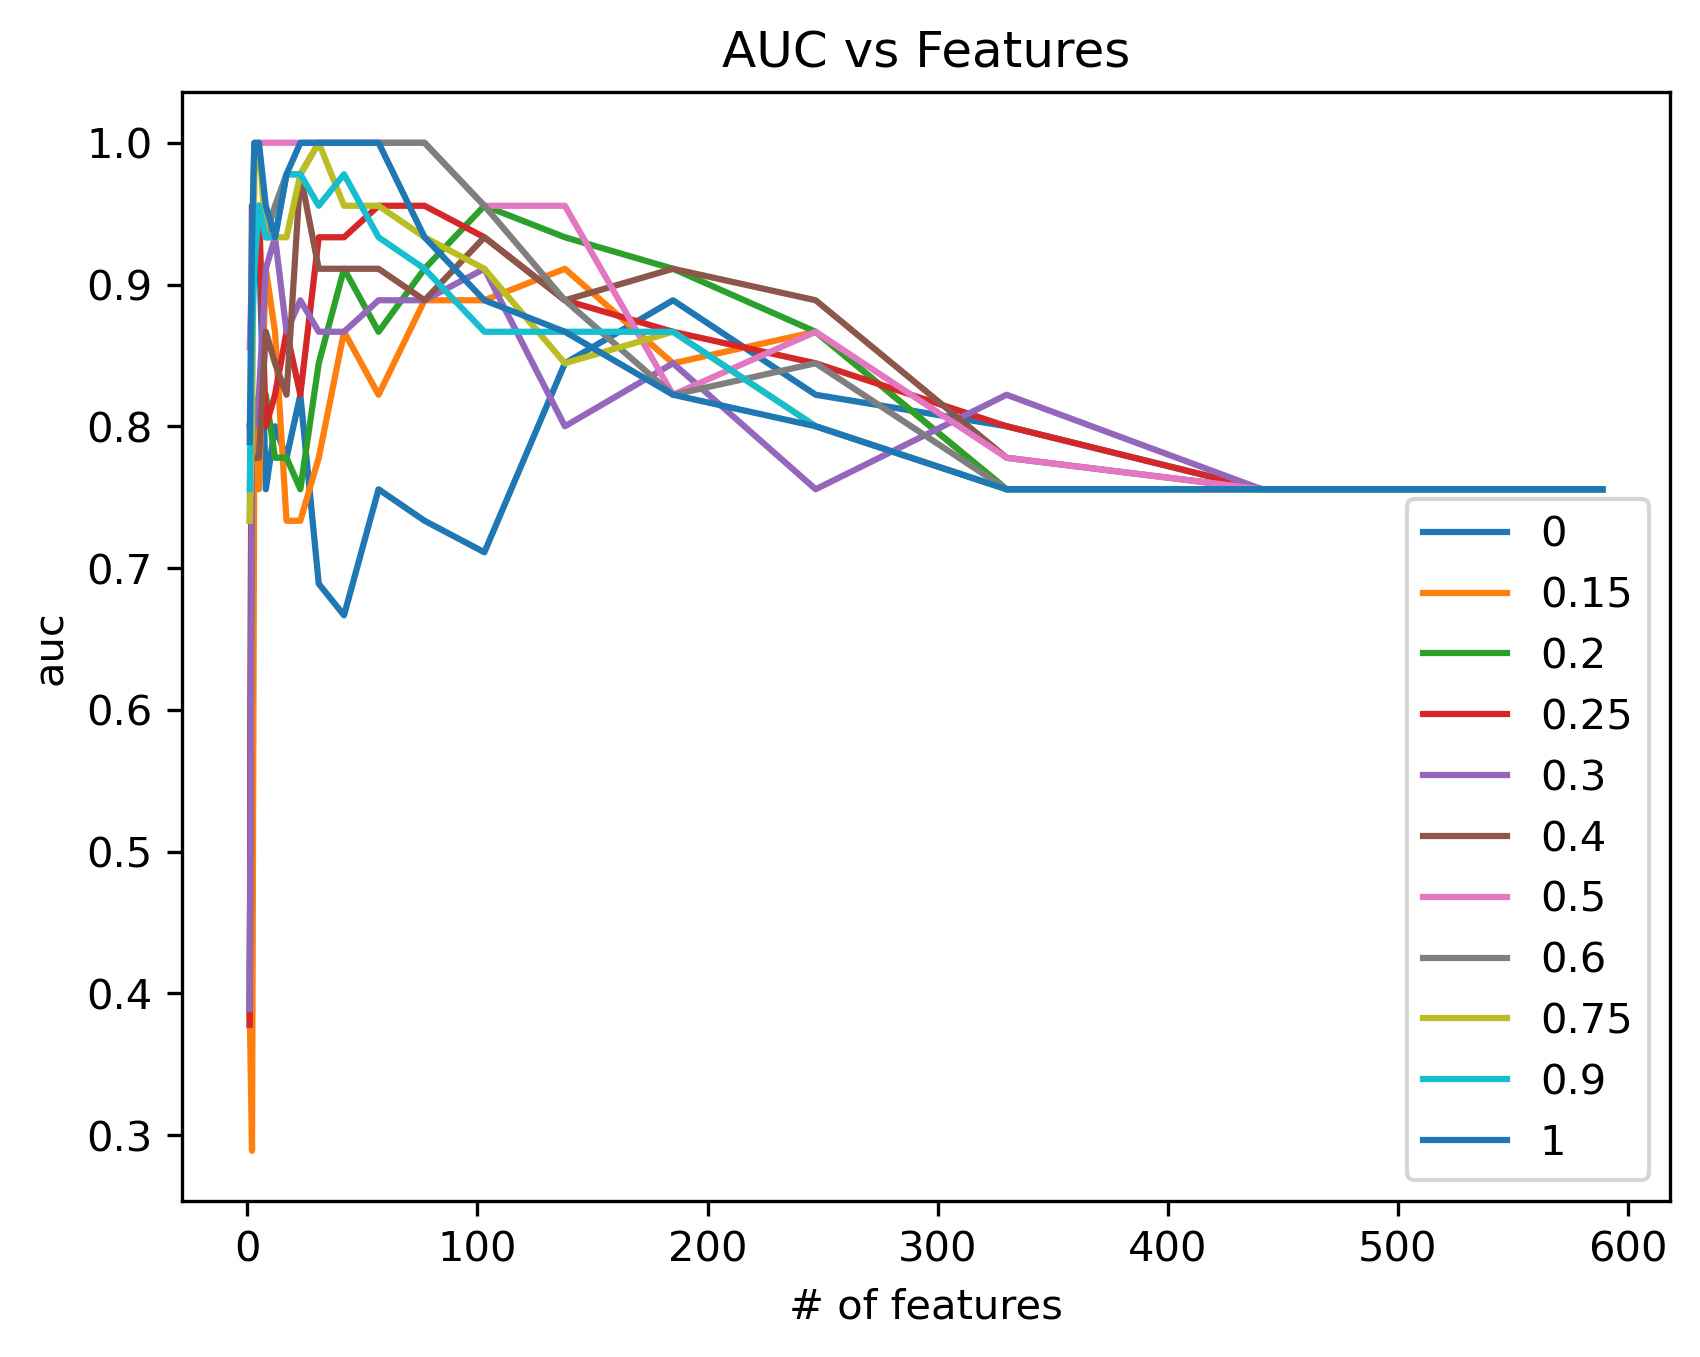

In [152]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

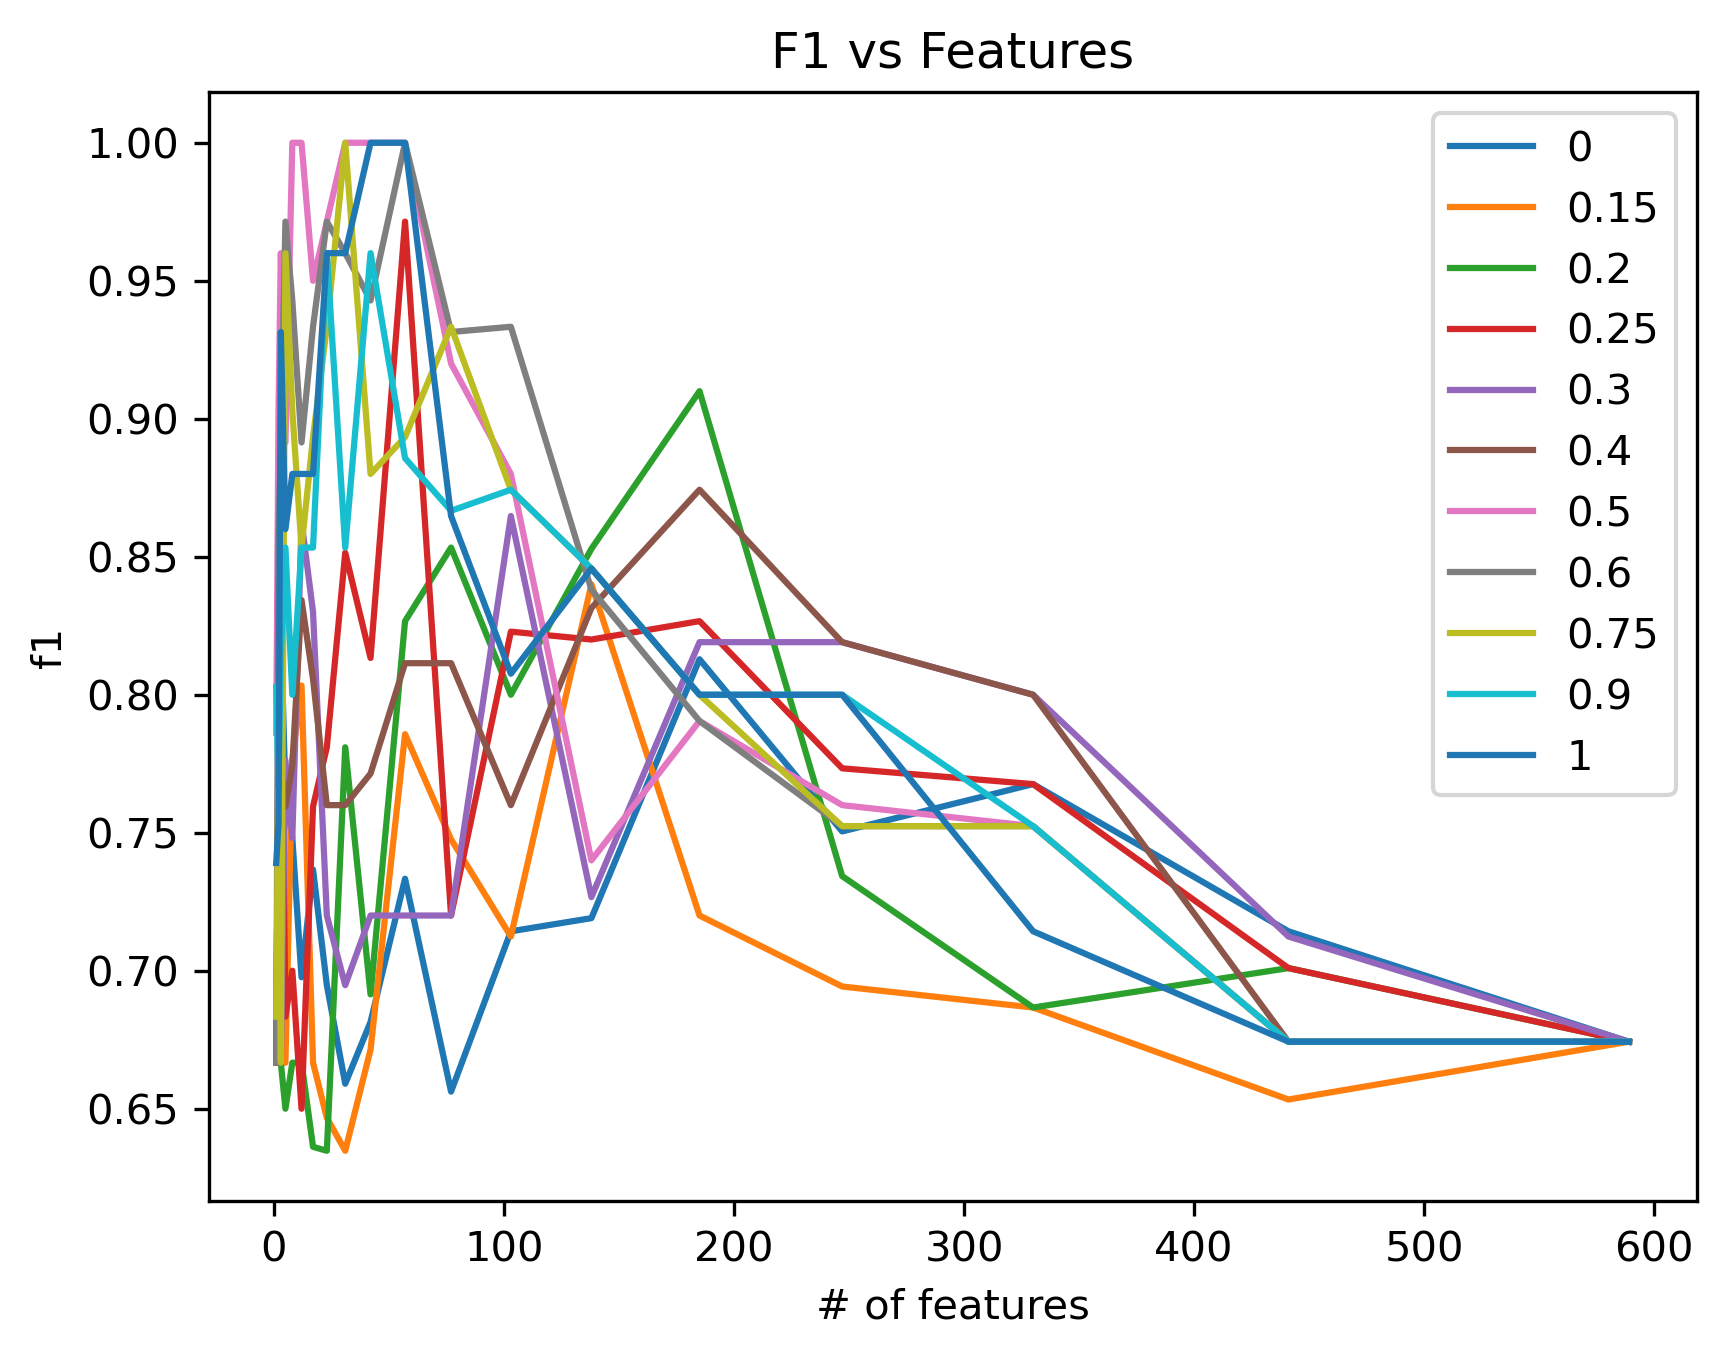

In [153]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

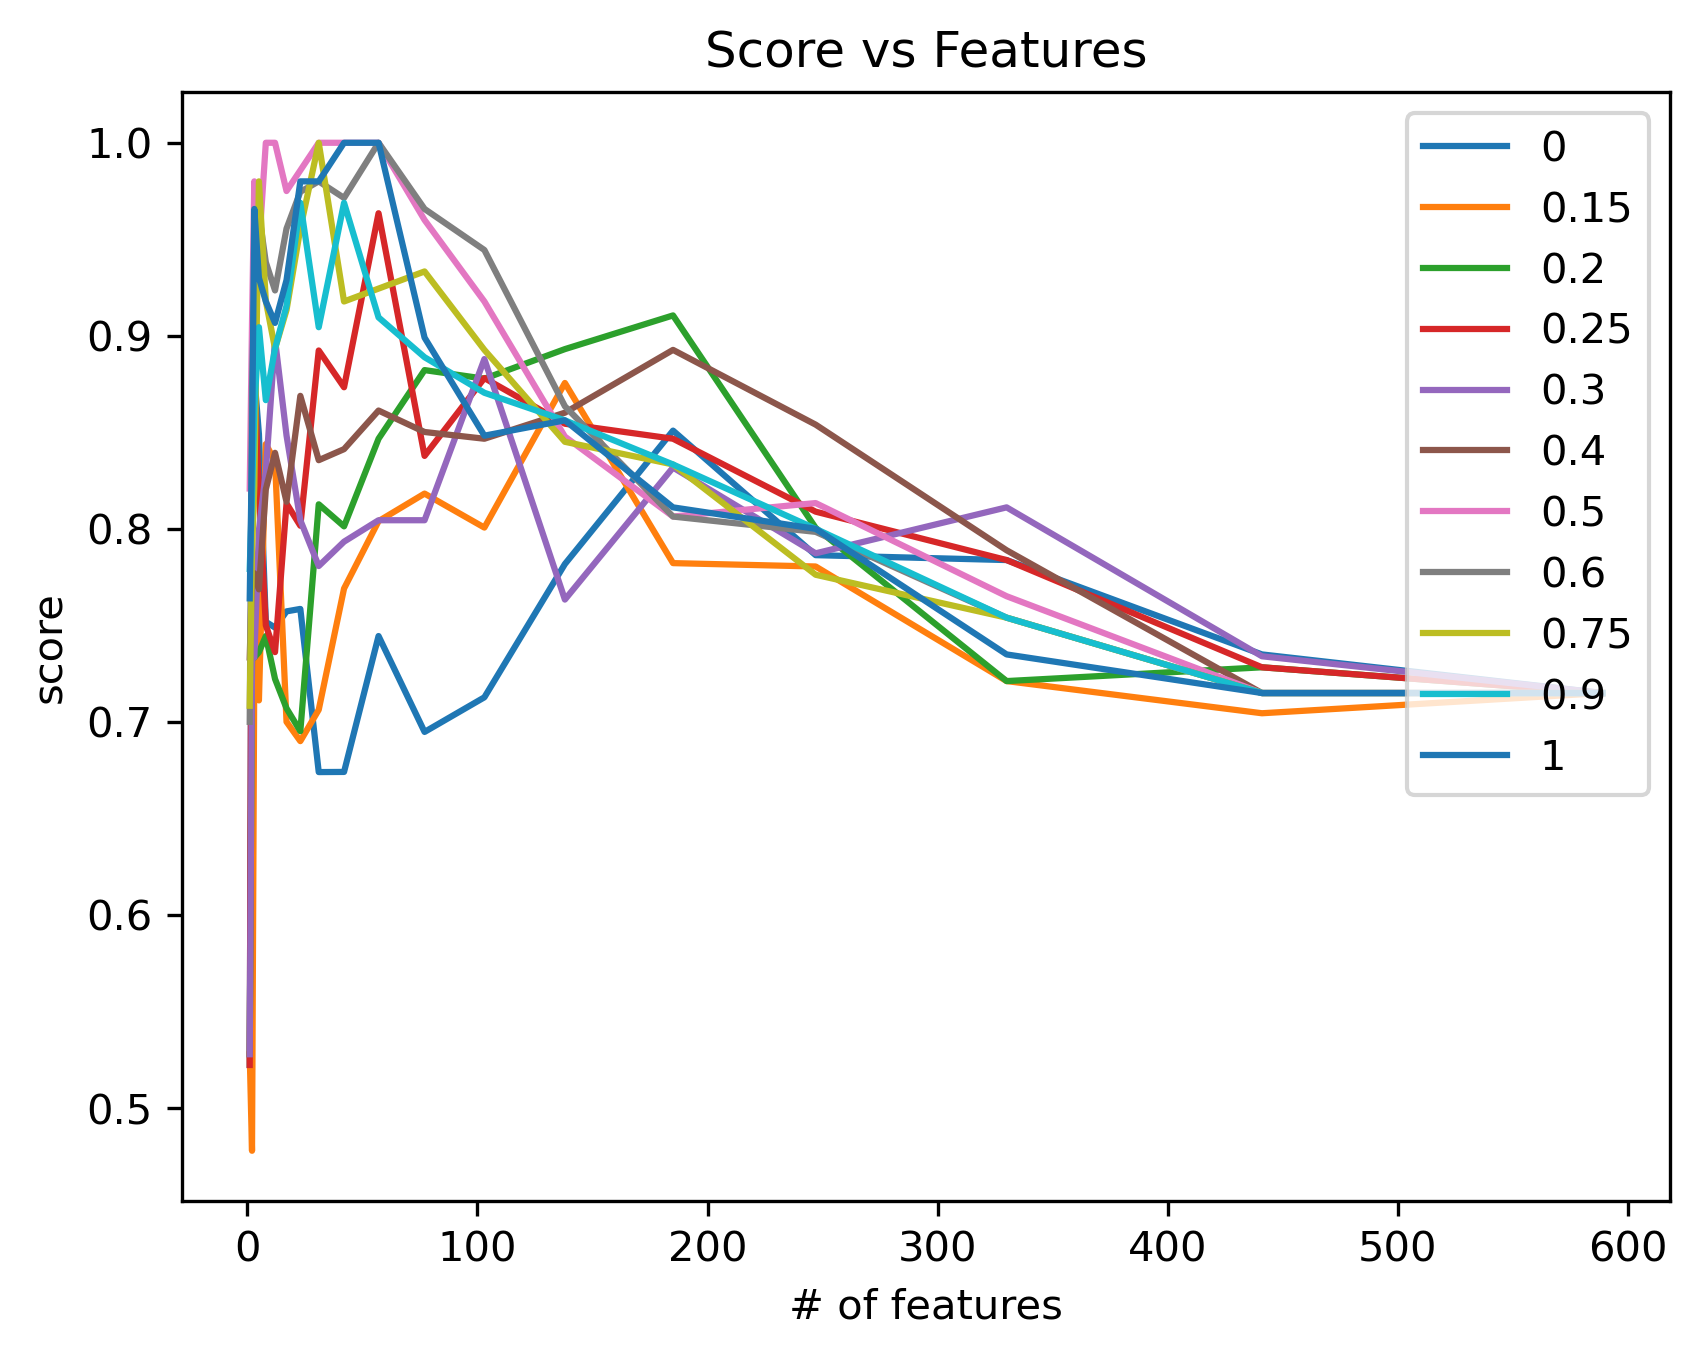

In [154]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "max"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

In [155]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.7563688791872153,
 0.7507933139299863,
 0.7809884927372194,
 0.7917280432263454,
 0.779399641577061,
 0.7955890398038107,
 0.802813350580753,
 0.7993968792950118,
 0.7895314226426281,
 0.7892563397741668,
 0.7889691971865146]

In [156]:
svm_set_ranks[selected_run].performance_

{'f1': 1.0,
 'auc': 1.0,
 'score': 1.0,
 'C': 0.125,
 'num_features': 8,
 'mean_nSV': 16.0}

In [157]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [158]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [159]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [160]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.571429  0.70       4.0        1.0        2.0       2.0   
0.15  0.888889  0.85       4.0        1.0        0.0       4.0   
0.2   0.888889  0.85       4.0        1.0        0.0       4.0   
0.25  0.600000  0.80       2.0        3.0        1.0       3.0   
0.3   0.571429  0.75       4.0        1.0        2.0       2.0   
0.4   0.888889  0.90       4.0        1.0        0.0       4.0   
0.5   0.800000  1.00       3.0        2.0        0.0       4.0   
0.6   0.800000  1.00       3.0        2.0        0.0       4.0   
0.75  0.888889  1.00       4.0        1.0        0.0       4.0   
0.9   0.888889  1.00       4.0        1.0        0.0       4.0   
1     0.800000  1.00       3.0        2.0        0.0       4.0   

      precision or PPV  recall or TPR  specificity or TNR  
0             0.666667           0.50                 0.8  
0.15          0.800000           1.00                 0.8  
0.2           0.800000           1.00                 0.8  
0.25          0.500000           0.75                 0.4  
0.3           0.666667           0.50                 0.8  
0.4           0.800000           1.00                 0.8  
0.5           0.666667           1.00                 0.6  
0.6           0.666667           1.00                 0.6  
0.75          0.800000           1.00                 0.8  
0.9           0.800000           1.00                 0.8  
1             0.666667           1.00                 0.6

In [161]:
df_performance

f1       auc     score          C  num_features  mean_nSV
0     0.824762  0.933333  0.879048  16.000000           3.0      19.0
0.15  0.840000  0.911111  0.875556   0.003906         138.0      27.8
0.2   0.910000  0.911111  0.910556   0.031250         185.0      20.2
0.25  0.971429  0.955556  0.963492   0.062500          57.0      17.6
0.3   0.862857  0.933333  0.898095   2.000000          12.0      17.0
0.4   0.874286  0.911111  0.892698   0.007812         185.0      22.0
0.5   1.000000  1.000000  1.000000   0.125000           8.0      16.0
0.6   1.000000  1.000000  1.000000   0.015625          57.0      21.0
0.75  1.000000  1.000000  1.000000   0.015625          31.0      21.6
0.9   0.960000  0.977778  0.968889   0.015625          23.0      23.4
1     1.000000  1.000000  1.000000   0.015625          42.0      21.2

In [162]:
df_features

0                         0.15  \
0            Creatinine_std                   sex_female   
1            Creatinine_75%                      dx_mgus   
2    NT Pro BNP_linear_coef                  RadiationTx   
3                       NaN             RadiationTx_True   
4                       NaN  Albumin Electrophoresis_std   
..                      ...                          ...   
180                     NaN                          NaN   
181                     NaN                          NaN   
182                     NaN                          NaN   
183                     NaN                          NaN   
184                     NaN                          NaN   

                                        0.2                       0.25  \
0                                sex_female                    dx_mgus   
1                                   dx_mgus               ChemoTx_True   
2                               RadiationTx                    BUN_25%   
3                          RadiationTx_True  Beta-2-Microglobulin_mean   
4                                  ALT_mean   Beta-2-Microglobulin_50%   
..                                      ...                        ...   
180       ECOG Performance Status_linear_r2                        NaN   
181  Karnofsky Performance Status_linear_r2                        NaN   
182         ECOG Performance Status_exp_mse                        NaN   
183          ECOG Performance Status_exp_r2                        NaN   
184     Karnofsky Performance Status_exp_r2                        NaN   

                           0.3                                       0.4  \
0    Beta-2-Microglobulin_mean                                   dx_mgus   
1     Beta-2-Microglobulin_75%                                       age   
2              Creatinine_mean                                  ImmunoTx   
3               Creatinine_std                              ChemoTx_True   
4               Creatinine_25%                             ImmunoTx_True   
..                         ...                                       ...   
180                        NaN          Karnofsky Performance Status_min   
181                        NaN  ECOG Performance Status_linear_intercept   
182                        NaN         ECOG Performance Status_linear_r2   
183                        NaN           ECOG Performance Status_exp_mse   
184                        NaN            ECOG Performance Status_exp_r2   

                                      0.5       0.6           0.75  \
0                                 BUN_50%  ImmunoTx        BUN_min   
1                            Chloride_25%   ALT_50%        BUN_25%   
2                  Immature Gran Auto_std  BUN_mean        BUN_50%   
3                              Sodium_50%   BUN_min  Chloride_mean   
4    Total Serum Protein_linear_intercept   BUN_25%   Chloride_min   
..                                    ...       ...            ...   
180                                   NaN       NaN            NaN   
181                                   NaN       NaN            NaN   
182                                   NaN       NaN            NaN   
183                                   NaN       NaN            NaN   
184                                   NaN       NaN            NaN   

                        0.9              1  
0                   BUN_50%       BUN_mean  
1             Chloride_mean        BUN_min  
2              Chloride_min        BUN_25%  
3              Chloride_25%        BUN_50%  
4    Immature Gran Auto_std  Chloride_mean  
..                      ...            ...  
180                     NaN            NaN  
181                     NaN            NaN  
182                     NaN            NaN  
183                     NaN            NaN  
184                     NaN            NaN  

[185 rows x 11 columns]

In [163]:
df_features['0.5'].dropna()

0                                 BUN_50%
1                            Chloride_25%
2                  Immature Gran Auto_std
3                              Sodium_50%
4    Total Serum Protein_linear_intercept
5                            MCV_exp_coef
6    Serum Electrophoresis Alpha 1_exp_r2
7                       Troponin-T_exp_r2
Name: 0.5, dtype: object

In [164]:
df_features['0.6'].dropna()

0                                    ImmunoTx
1                                     ALT_50%
2                                    BUN_mean
3                                     BUN_min
4                                     BUN_25%
5                                     BUN_50%
6                   Beta-2-Microglobulin_mean
7                               Chloride_mean
8                                Chloride_min
9                                Chloride_25%
10                               Chloride_50%
11                               Chloride_75%
12                             Creatinine_min
13                             Creatinine_25%
14                             Creatinine_50%
15                     Immature Gran Auto_std
16                Pct Immature Gran Auto_mean
17                               Pct Mono_25%
18                         Platelet Count_min
19         Serum Electrophoresis Alpha 2_mean
20          Serum Electrophoresis Alpha 2_75%
21             Serum Electrophores

In [165]:
df_features['0.4'].dropna()

0                                       dx_mgus
1                                           age
2                                      ImmunoTx
3                                  ChemoTx_True
4                                 ImmunoTx_True
                         ...                   
180            Karnofsky Performance Status_min
181    ECOG Performance Status_linear_intercept
182           ECOG Performance Status_linear_r2
183             ECOG Performance Status_exp_mse
184              ECOG Performance Status_exp_r2
Name: 0.4, Length: 185, dtype: object

## best model performance

In [166]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0.5
f1               1.000
auc              1.000
score            1.000
C                0.125
num_features     8.000
mean_nSV        16.000
Name: 0.5, dtype: float64
f1                    0.800000
auc                   1.000000
true neg              3.000000
false pos             2.000000
false neg             0.000000
true pos              4.000000
precision or PPV      0.666667
recall or TPR         1.000000
specificity or TNR    0.600000
Name: 0.5, dtype: float64


In [167]:
df_features[str(rank_weights[selected_run])].dropna()

0                                 BUN_50%
1                            Chloride_25%
2                  Immature Gran Auto_std
3                              Sodium_50%
4    Total Serum Protein_linear_intercept
5                            MCV_exp_coef
6    Serum Electrophoresis Alpha 1_exp_r2
7                       Troponin-T_exp_r2
Name: 0.5, dtype: object

## pair plots

Text(0.5, 1.08, 'Rank weight: 0.50')

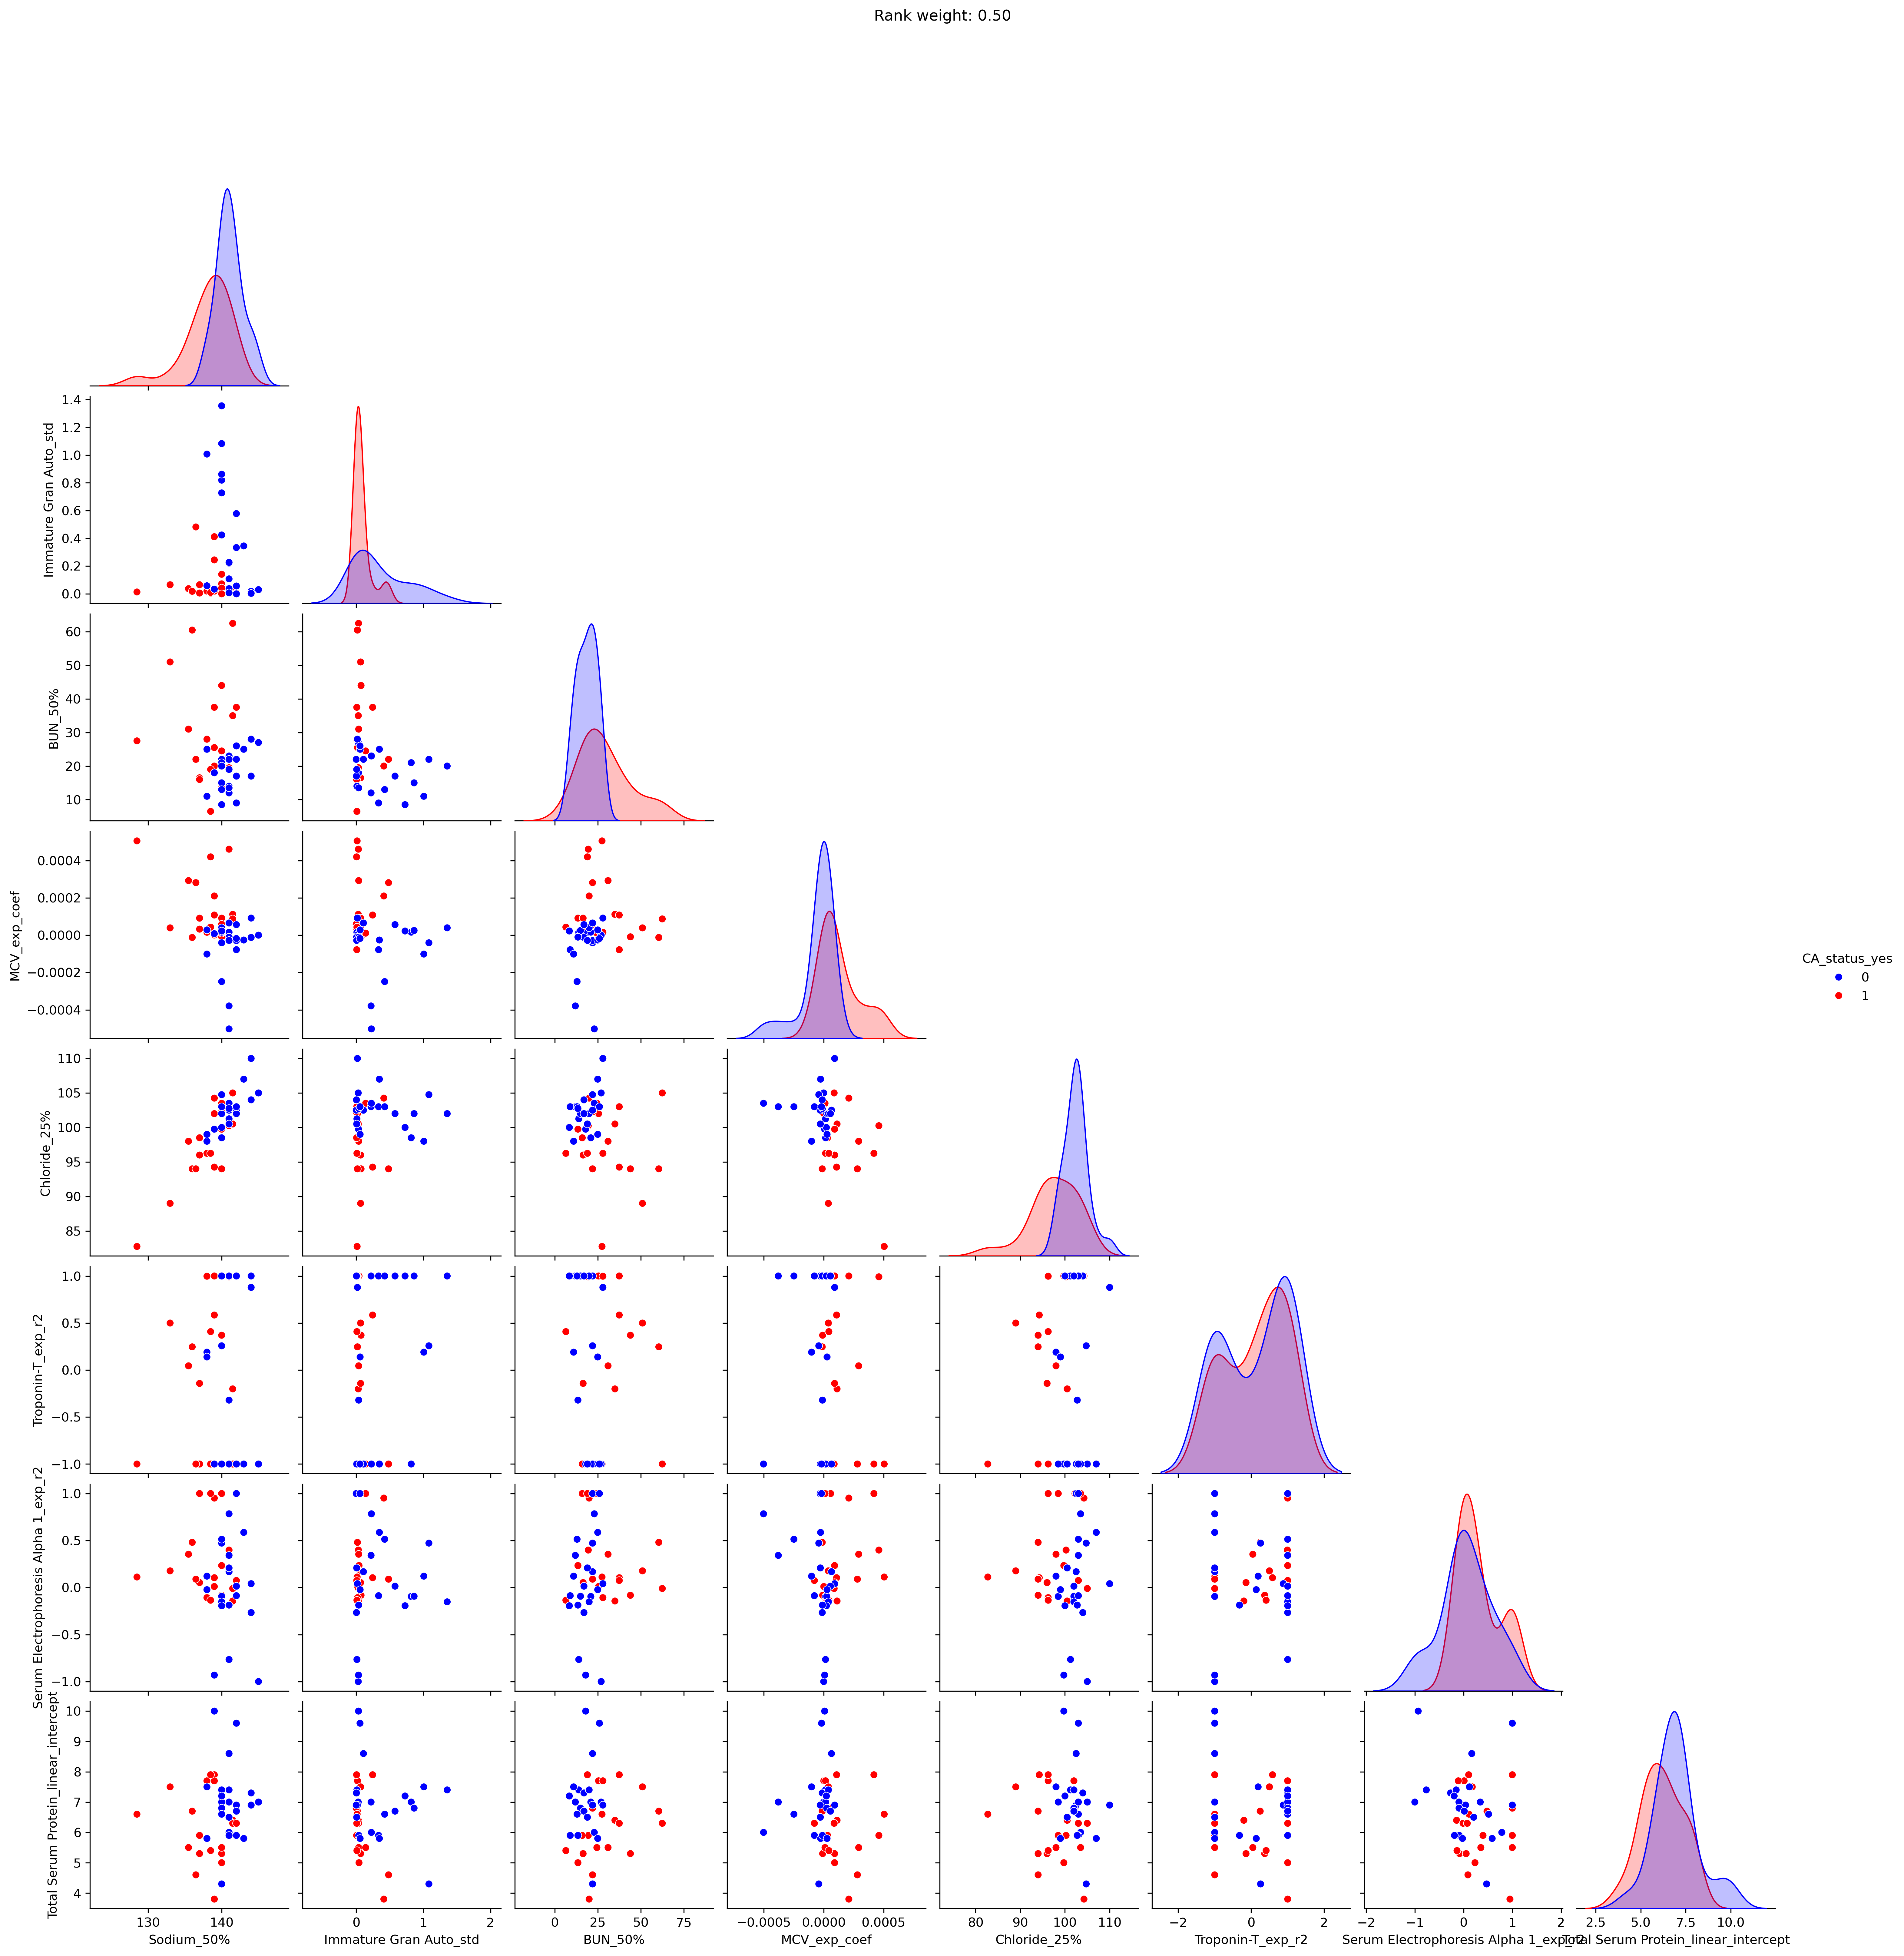

In [168]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [169]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [170]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



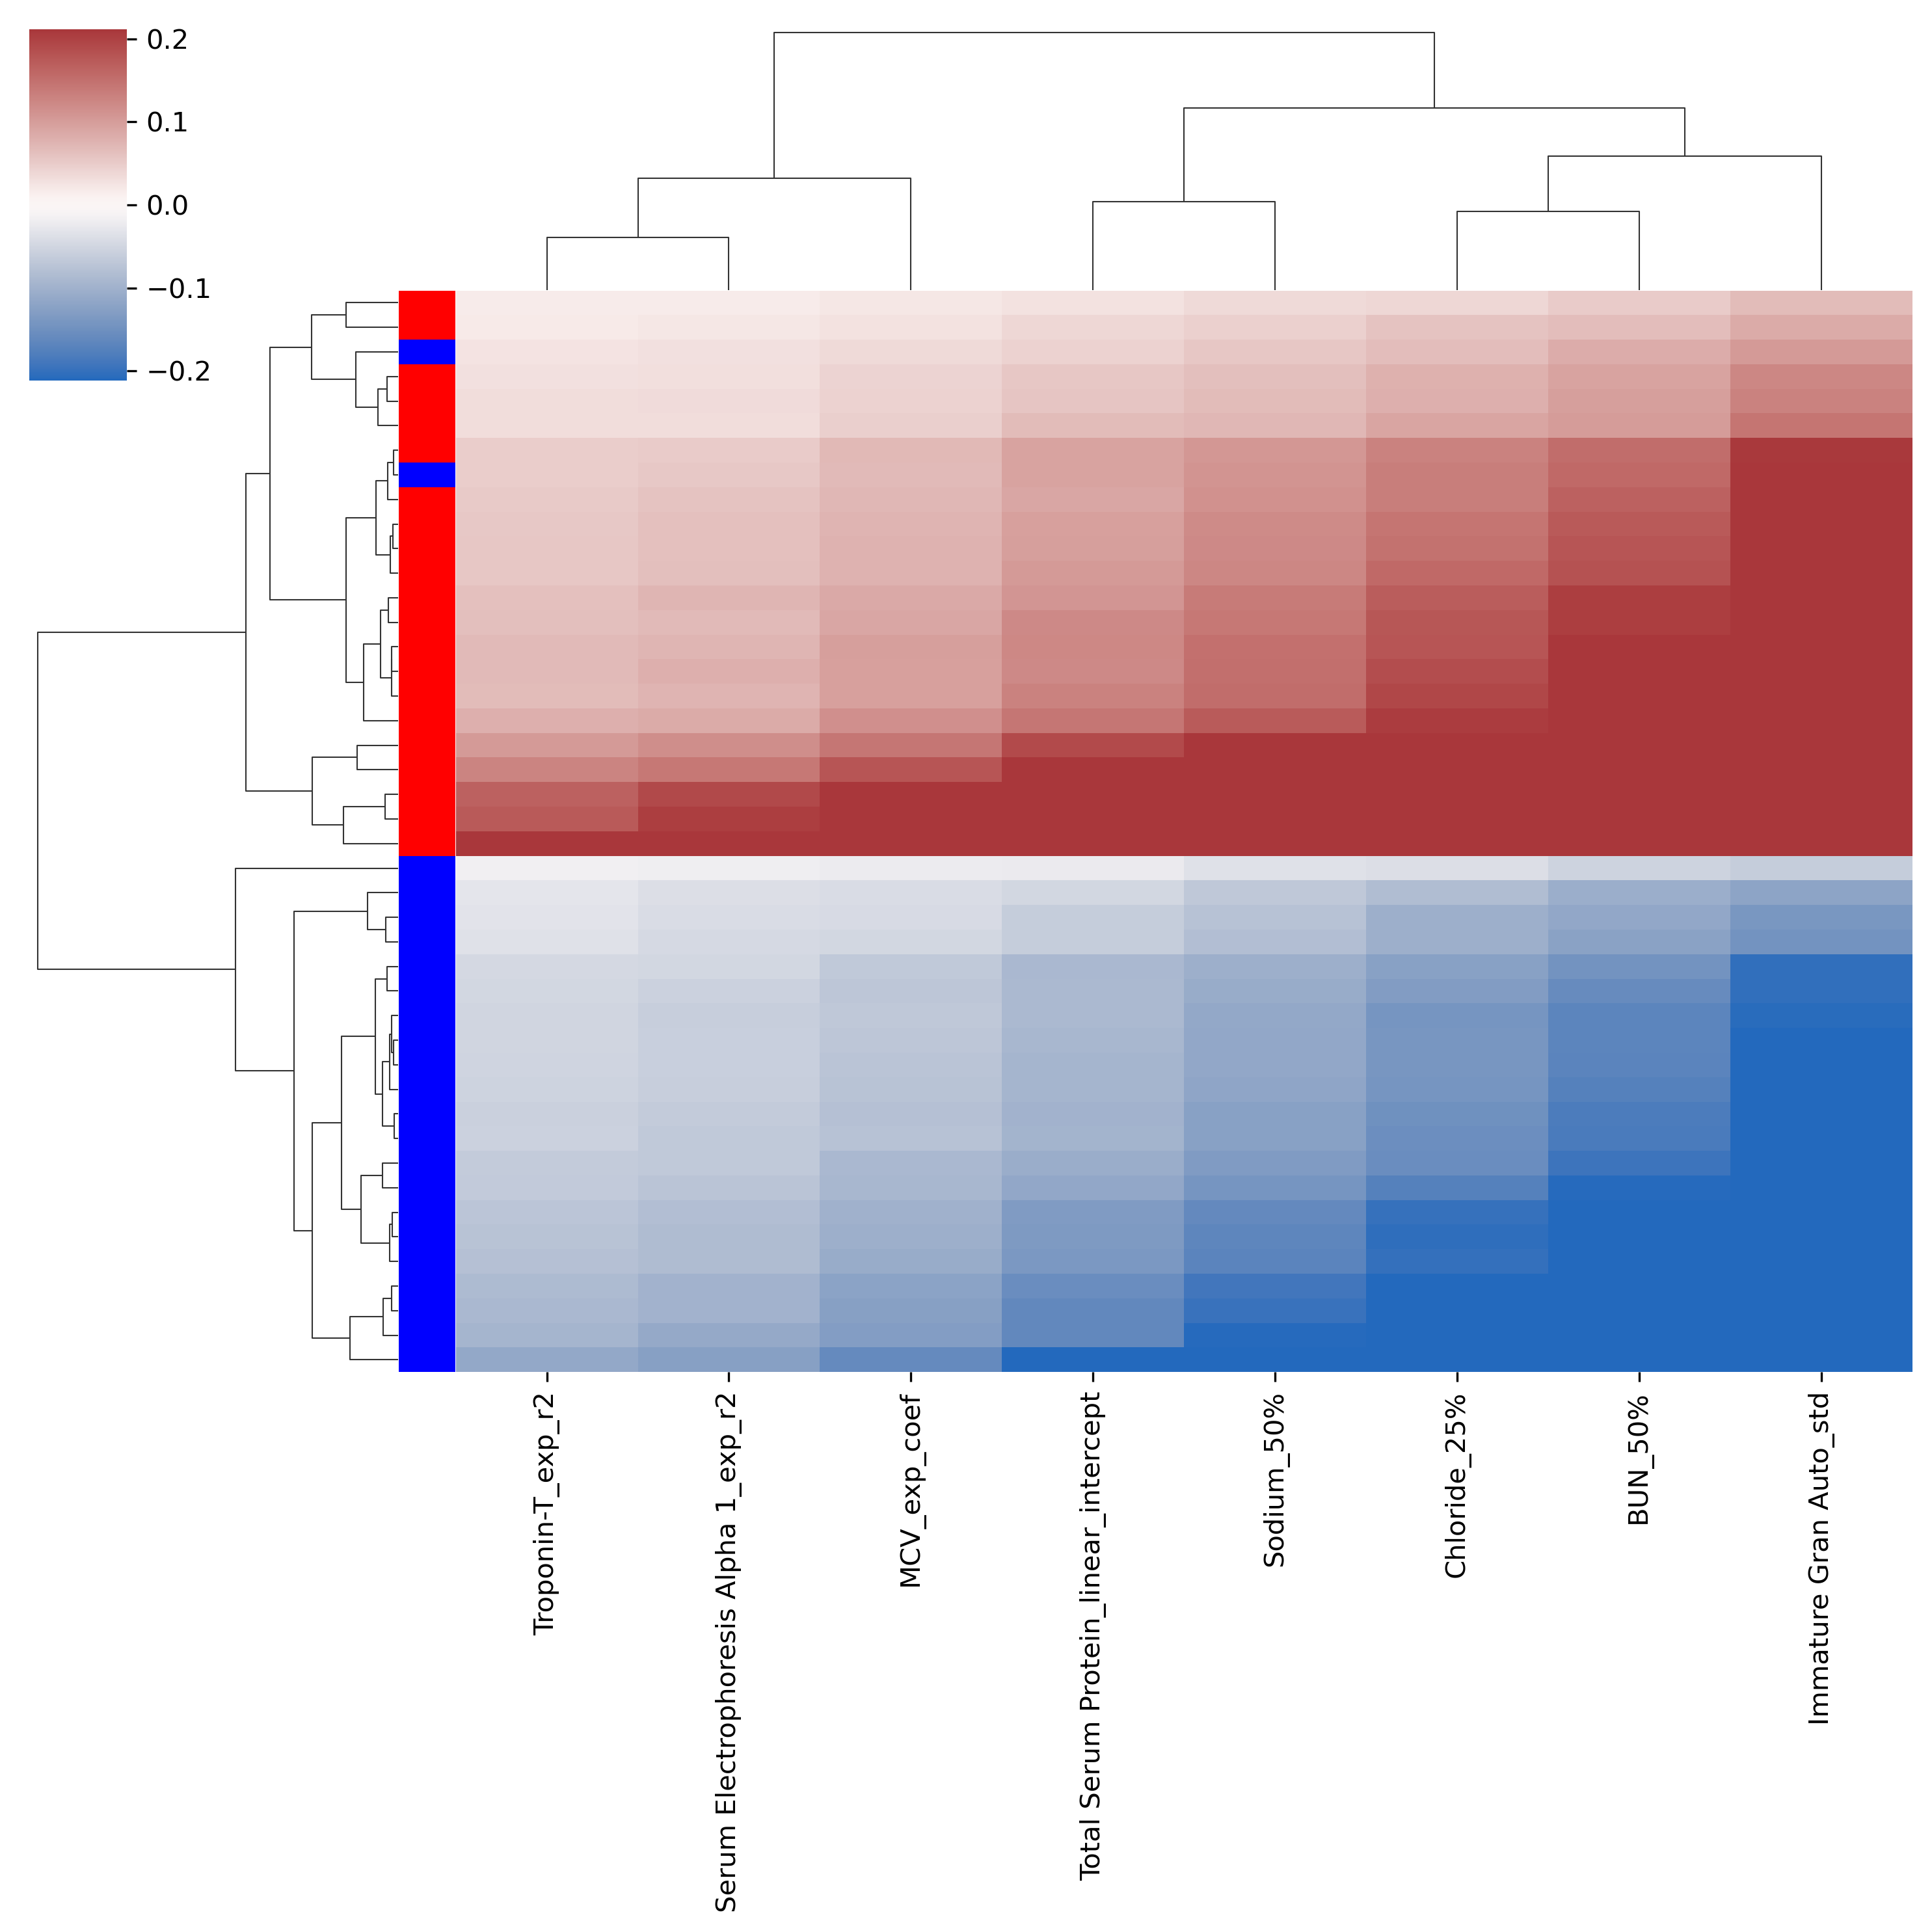

In [171]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [172]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [173]:
# nbins = 10
# scale = 0.1
# n_features = 12
# spacing = 2
# min_max_IG = 2.5

# fig = go.Figure()
# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=1000,
#     height=2000,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = "Integrated Gradient",
# )
 
# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     range = [-min_max_IG,min_max_IG]
#     )
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey',
#     range = [-spacing, spacing*n_features + spacing]
# )
 
# feature_rank = np.argsort(np.sum(abs(IG),axis=0))
# feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

# y_val = 1
# bin_ids = list(range(nbins))
# for f in feature_order:
#     bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
#     ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
#     x_vals = []
#     y_vals = []
#     f_vals = []
#     for bin in bin_ids:
#         x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
#         n_pts = len(x_bin_vals)
#         if n_pts > 0:
#             x_vals = x_vals + x_bin_vals
#             y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
#             f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
#     fig.add_trace(go.Scatter(
#         x = x_vals, 
#         y = y_vals,
#         mode = 'markers',
#         marker = dict(size=12,
#                       color = f_vals,
#                       coloraxis = "coloraxis",
#                      ),
#         name=IGtable.columns[f],
#     ))
#     y_val += spacing
 
 
# fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text="Feature Value",side = "right"),
#                     cmin = -1, cmax = 1)
# fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
#                  ticktext=IGtable.columns[feature_order])
 
# fig.show()

In [174]:
feat_1 = IGtable.columns[feature_order[6]]
feat_2 = IGtable.columns[feature_order[5]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [175]:
feat_1 = IGtable.columns[feature_order[5]]
feat_2 = IGtable.columns[feature_order[6]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

# sensitivity and specificity 

In [176]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  3
false positive:  2
false negative:  0
true positive:  4
true positive rate or recall/sensitivity:  1.0
positive predictive value or precision:  0.6666666666666666
specificity or true negatie rate:  0.6
auc:  1.0
f1 score:  0.8


# testing alt models on best feature list

In [177]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [178]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

ROC:  0.9
F1:  0.8888888888888888


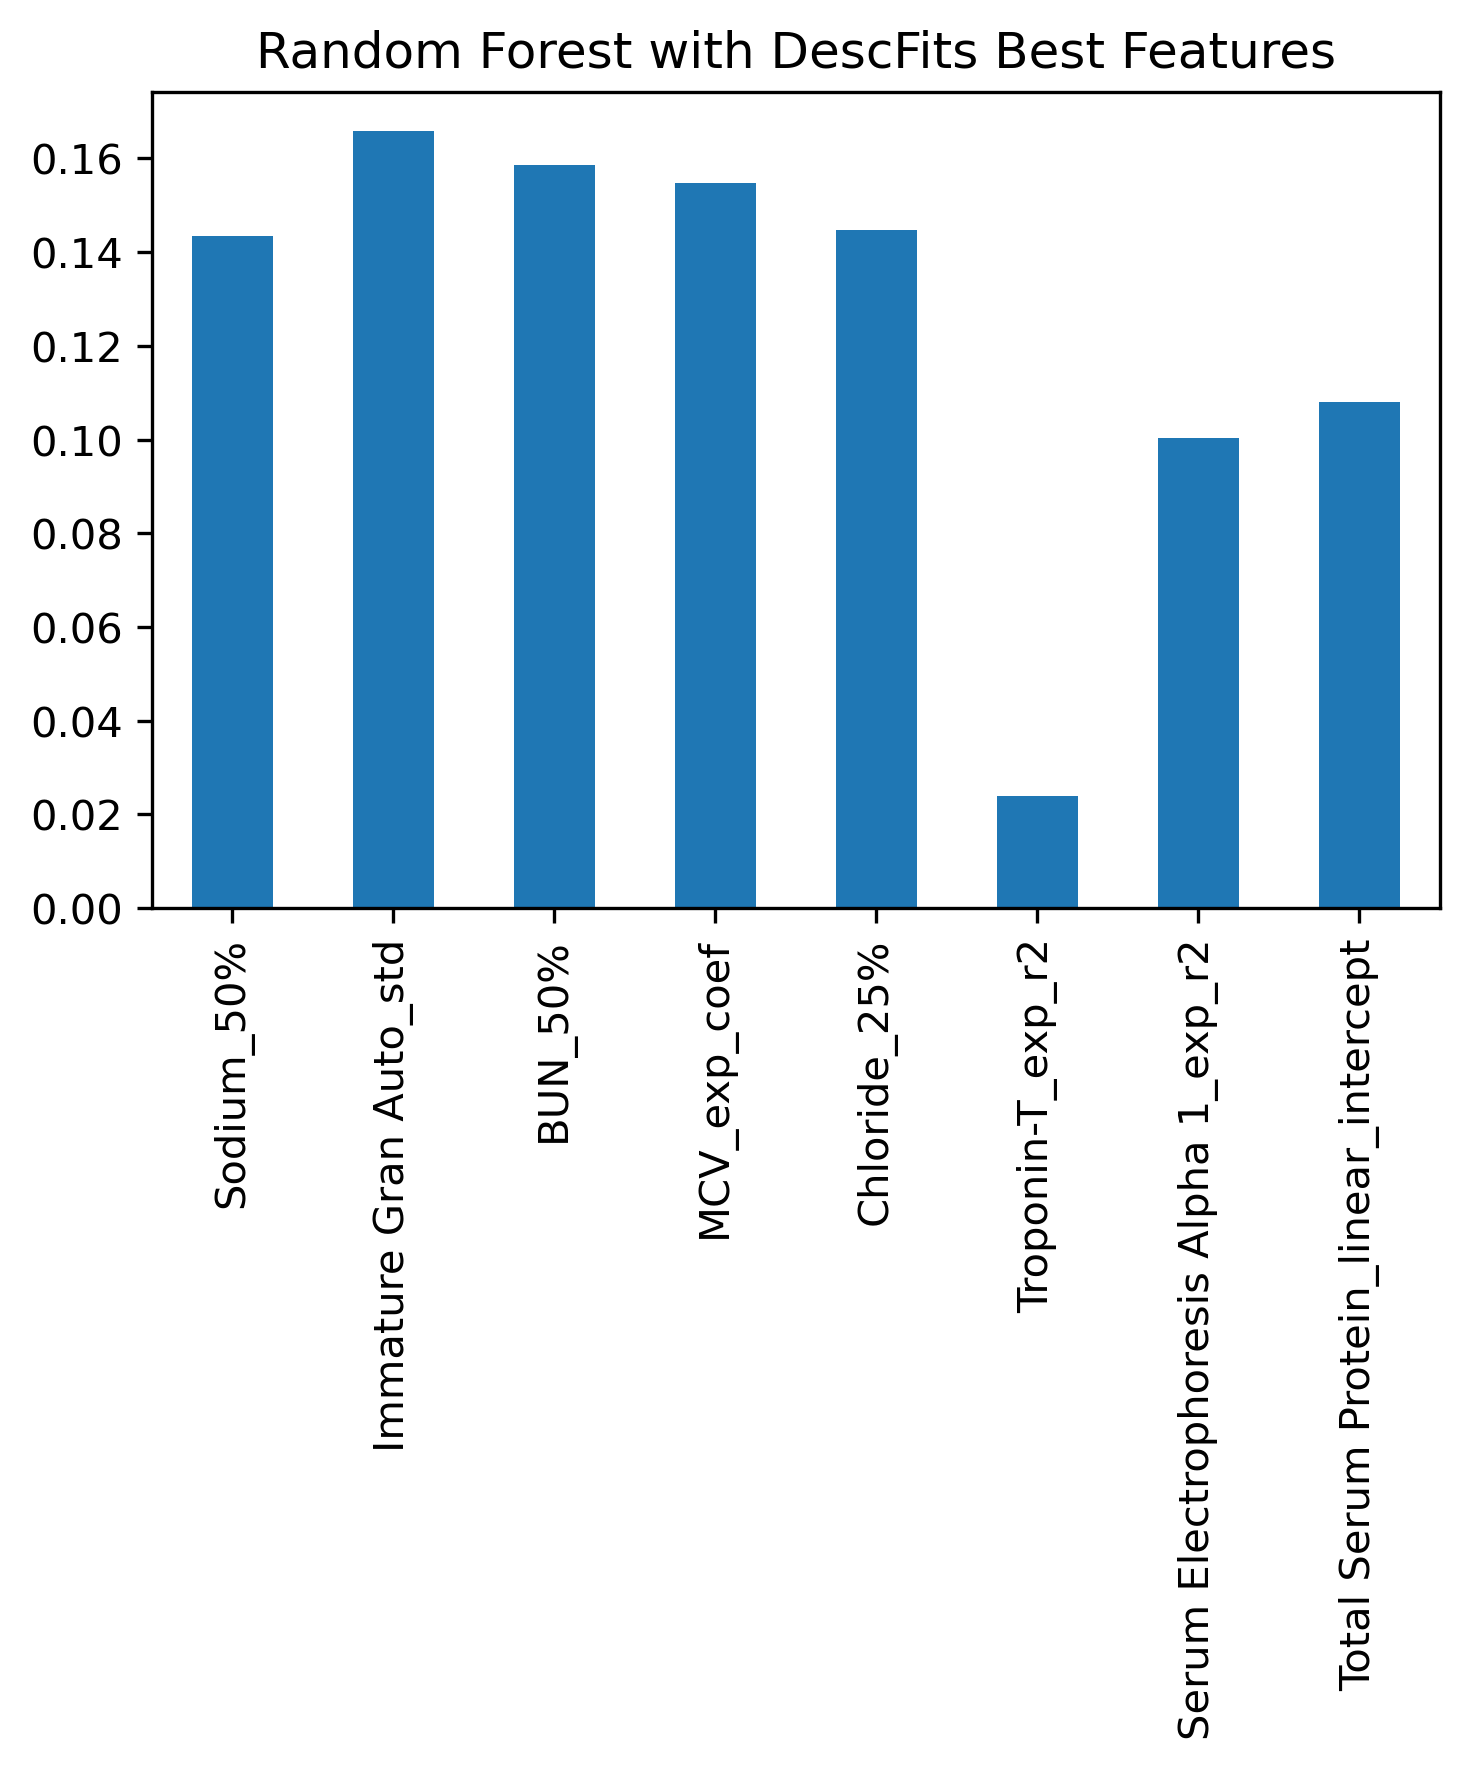

In [179]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with DescFits Best Features")
fig.tight_layout()

ROC:  0.9
F1:  0.8888888888888888


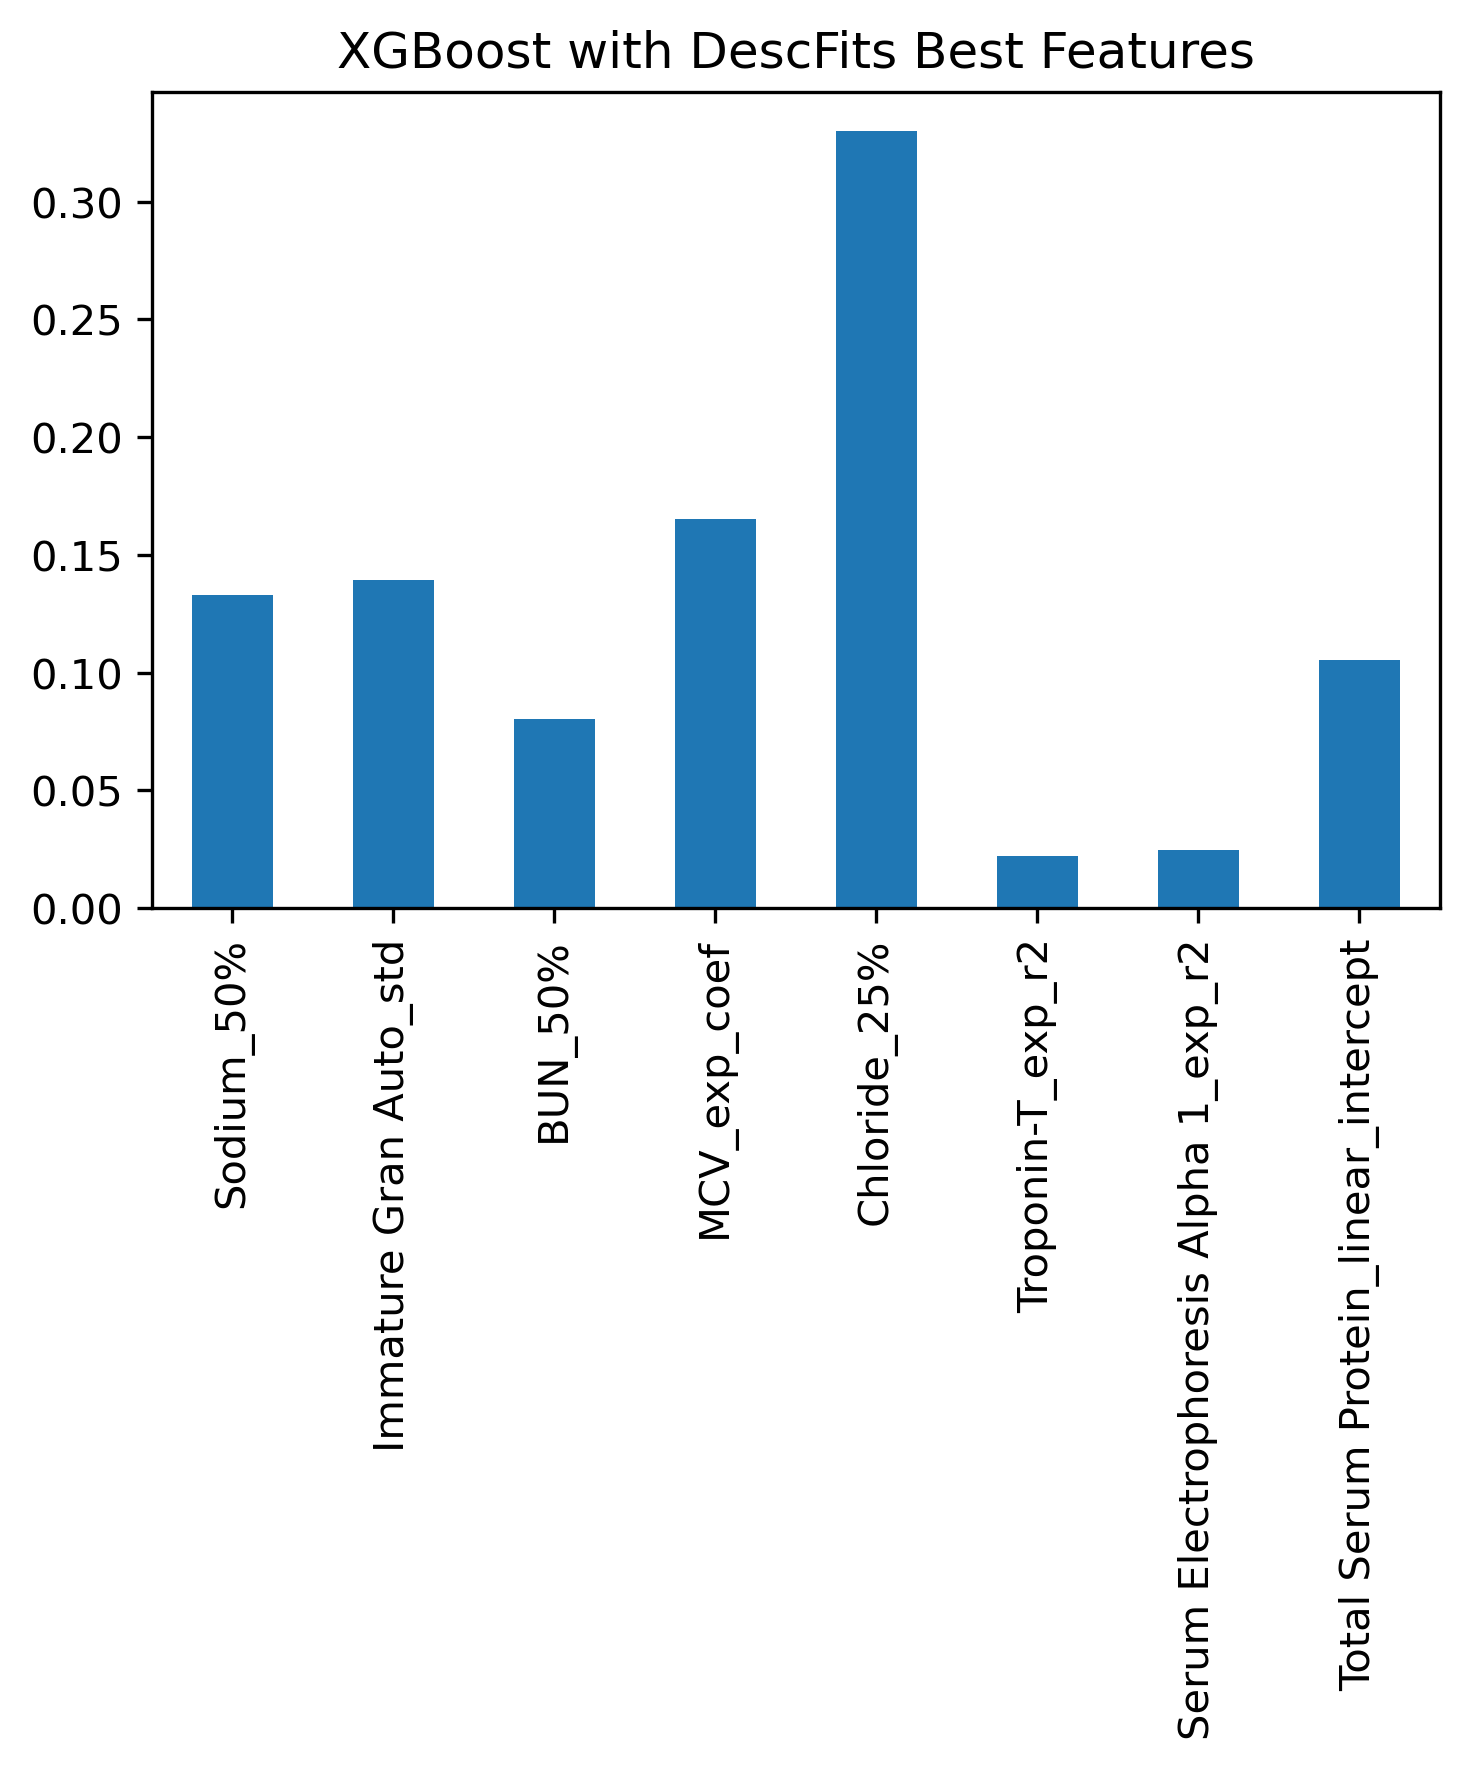

In [180]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with DescFits Best Features")
fig.tight_layout()

In [181]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



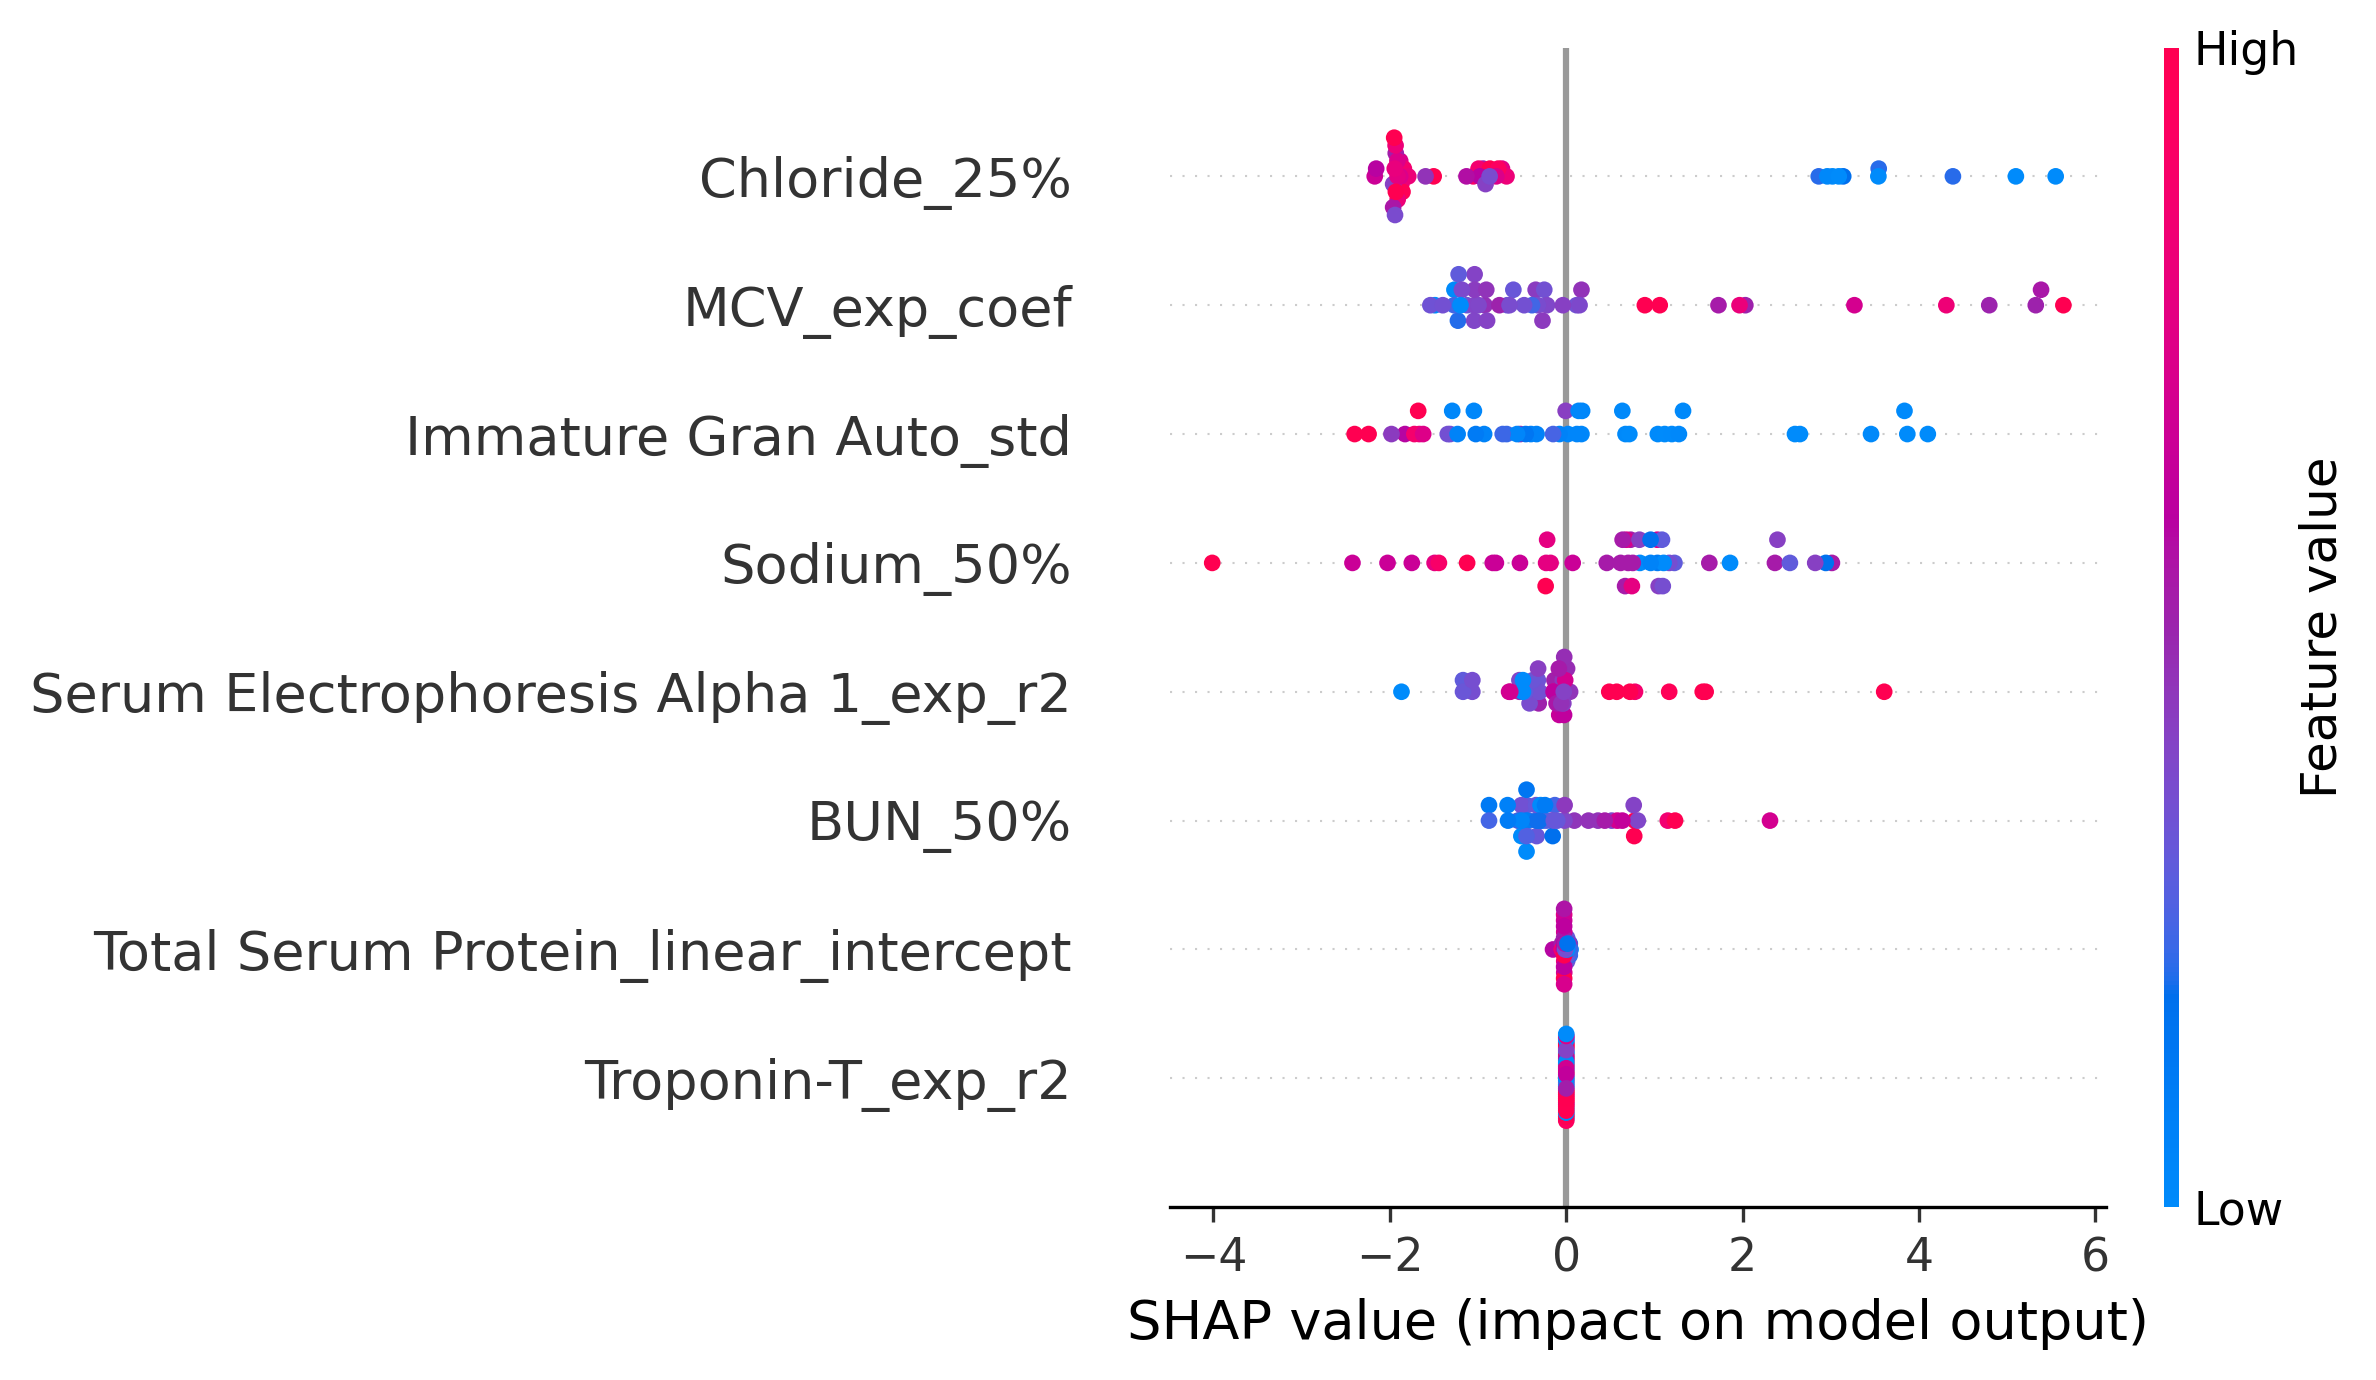

In [182]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# correlation and heat maps for the best performing features of the SVM model

In [183]:
import seaborn as sns

In [184]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
0   B-02              1           0        1      0   48      9.466667   
1   C-03              1           1        0      1   59     17.000000   
2   E-01              1           0        1      0   50     71.300000   
3   E-02              1           0        1      0   64     20.466667   
4   F-03              1           0        0      1   61     52.000000   
5   G-02              1           1        0      1   36     30.000000   
6   I-01              1           1        0      1   55     33.000000   
7   I-03              1           0        1      0   67     10.033333   
8   J-02              1           1        0      1   68     26.000000   
9   K-02              1           1        0      1   68     27.000000   
10  M-02              1           0        1      0   70     24.800000   
11  N-03              1           0        0      1   69      8.000000   
12  O-03              1           1        0      1   71      4.233333   
13  Q-02              1           0        1      0   69     41.100000   
14  Q-03              1           1        0      1   41      3.466667   
15  T-01              1           0        0      0   71     14.433333   
16  V-02              1           0        0      1   79     50.000000   
17  W-01              1           0        0      1   57     42.000000   
18  X-01              1           0        1      0   80      5.300000   
19  X-02              1           0        1      0   63     38.233333   
20  Y-02              1           1        1      0   57     12.766667   
21  A-02              0           1        1      0   74      7.266667   
22  B-03              0           0        0      1   43     18.000000   
23  C-01              0           1        0      0   56     27.000000   
24  C-02              0           0        0      1   59     33.000000   
25  E-03              0           0        1      0   62     13.866667   
26  F-01              0           0        0      1   55    147.000000   
27  G-03              0           1        1      0   69     11.533333   
28  H-01              0           0        1      0   56     47.066667   
29  H-02              0           0        0      1   65     26.000000   
30  M-01              0           0        0      1   47     83.000000   
31  N-01              0           0        0      0   79     15.000000   
32  N-02              0           0        0      1   76     10.000000   
33  P-01              0           0        0      1   77     53.000000   
34  P-02              0           1        0      1   64     26.000000   
35  Q-01              0           1        1      0   57     48.800000   
36  R-01              0           0        0      1   68     21.000000   
37  R-03              0           1        1      0   62     12.966667   
38  S-02              0           1        0      1   69     20.000000   
39  T-02              0           0        0      1   60     19.000000   
40  V-01              0           1        0      1   66     43.000000   
41  W-02              0           0        1      0   72     13.500000   
42  Y-01              0           0        0      1   59     40.000000   
43  Z-01              0           1        0      0   72      2.000000   

    ChemoTx  HematologicTx  RadiationTx  ...  \
0         0              0            0  ...   
1         2              0            0  ...   
2         0              0            0  ...   
3         0              0            0  ...   
4         4              1            0  ...   
5         0              0            0  ...   
6         4              0            0  ...   
7         0              0            0  ...   
8         1              0            0  ...   
9         1              0            0  ...   
10        0              0            0  ...   
11        0              0            0  ...   
12        0              0            0  ...   
1

In [185]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [186]:
colormap = "RdBu"

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



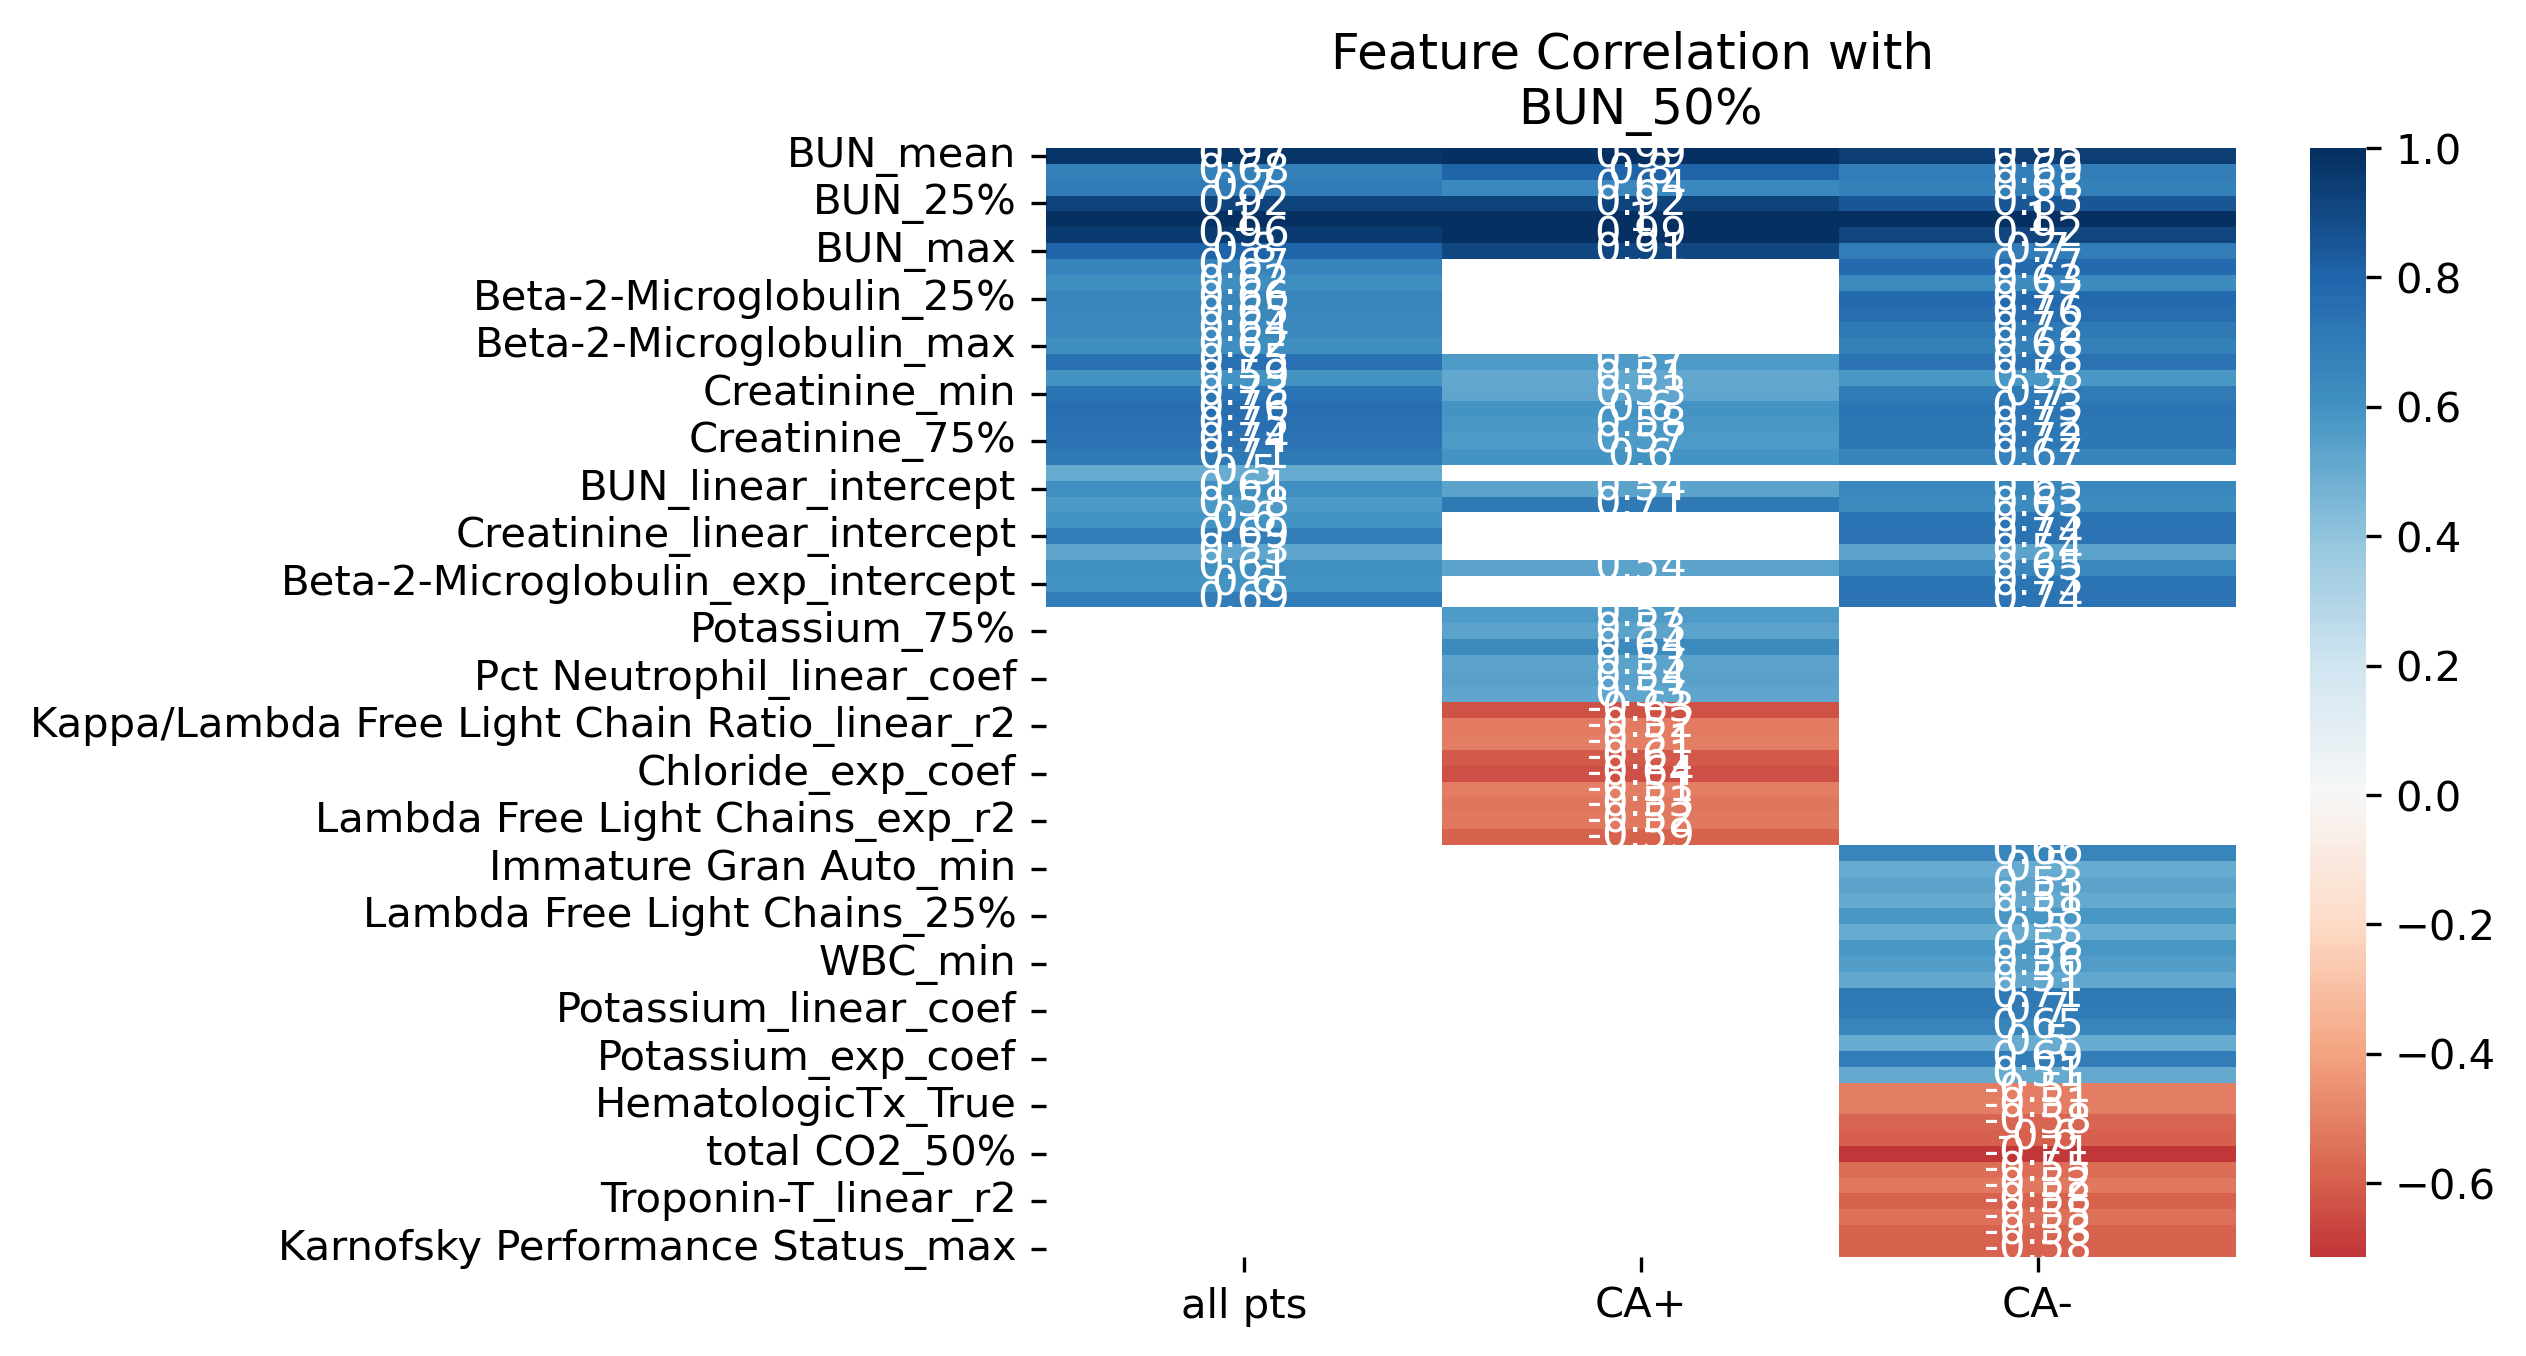

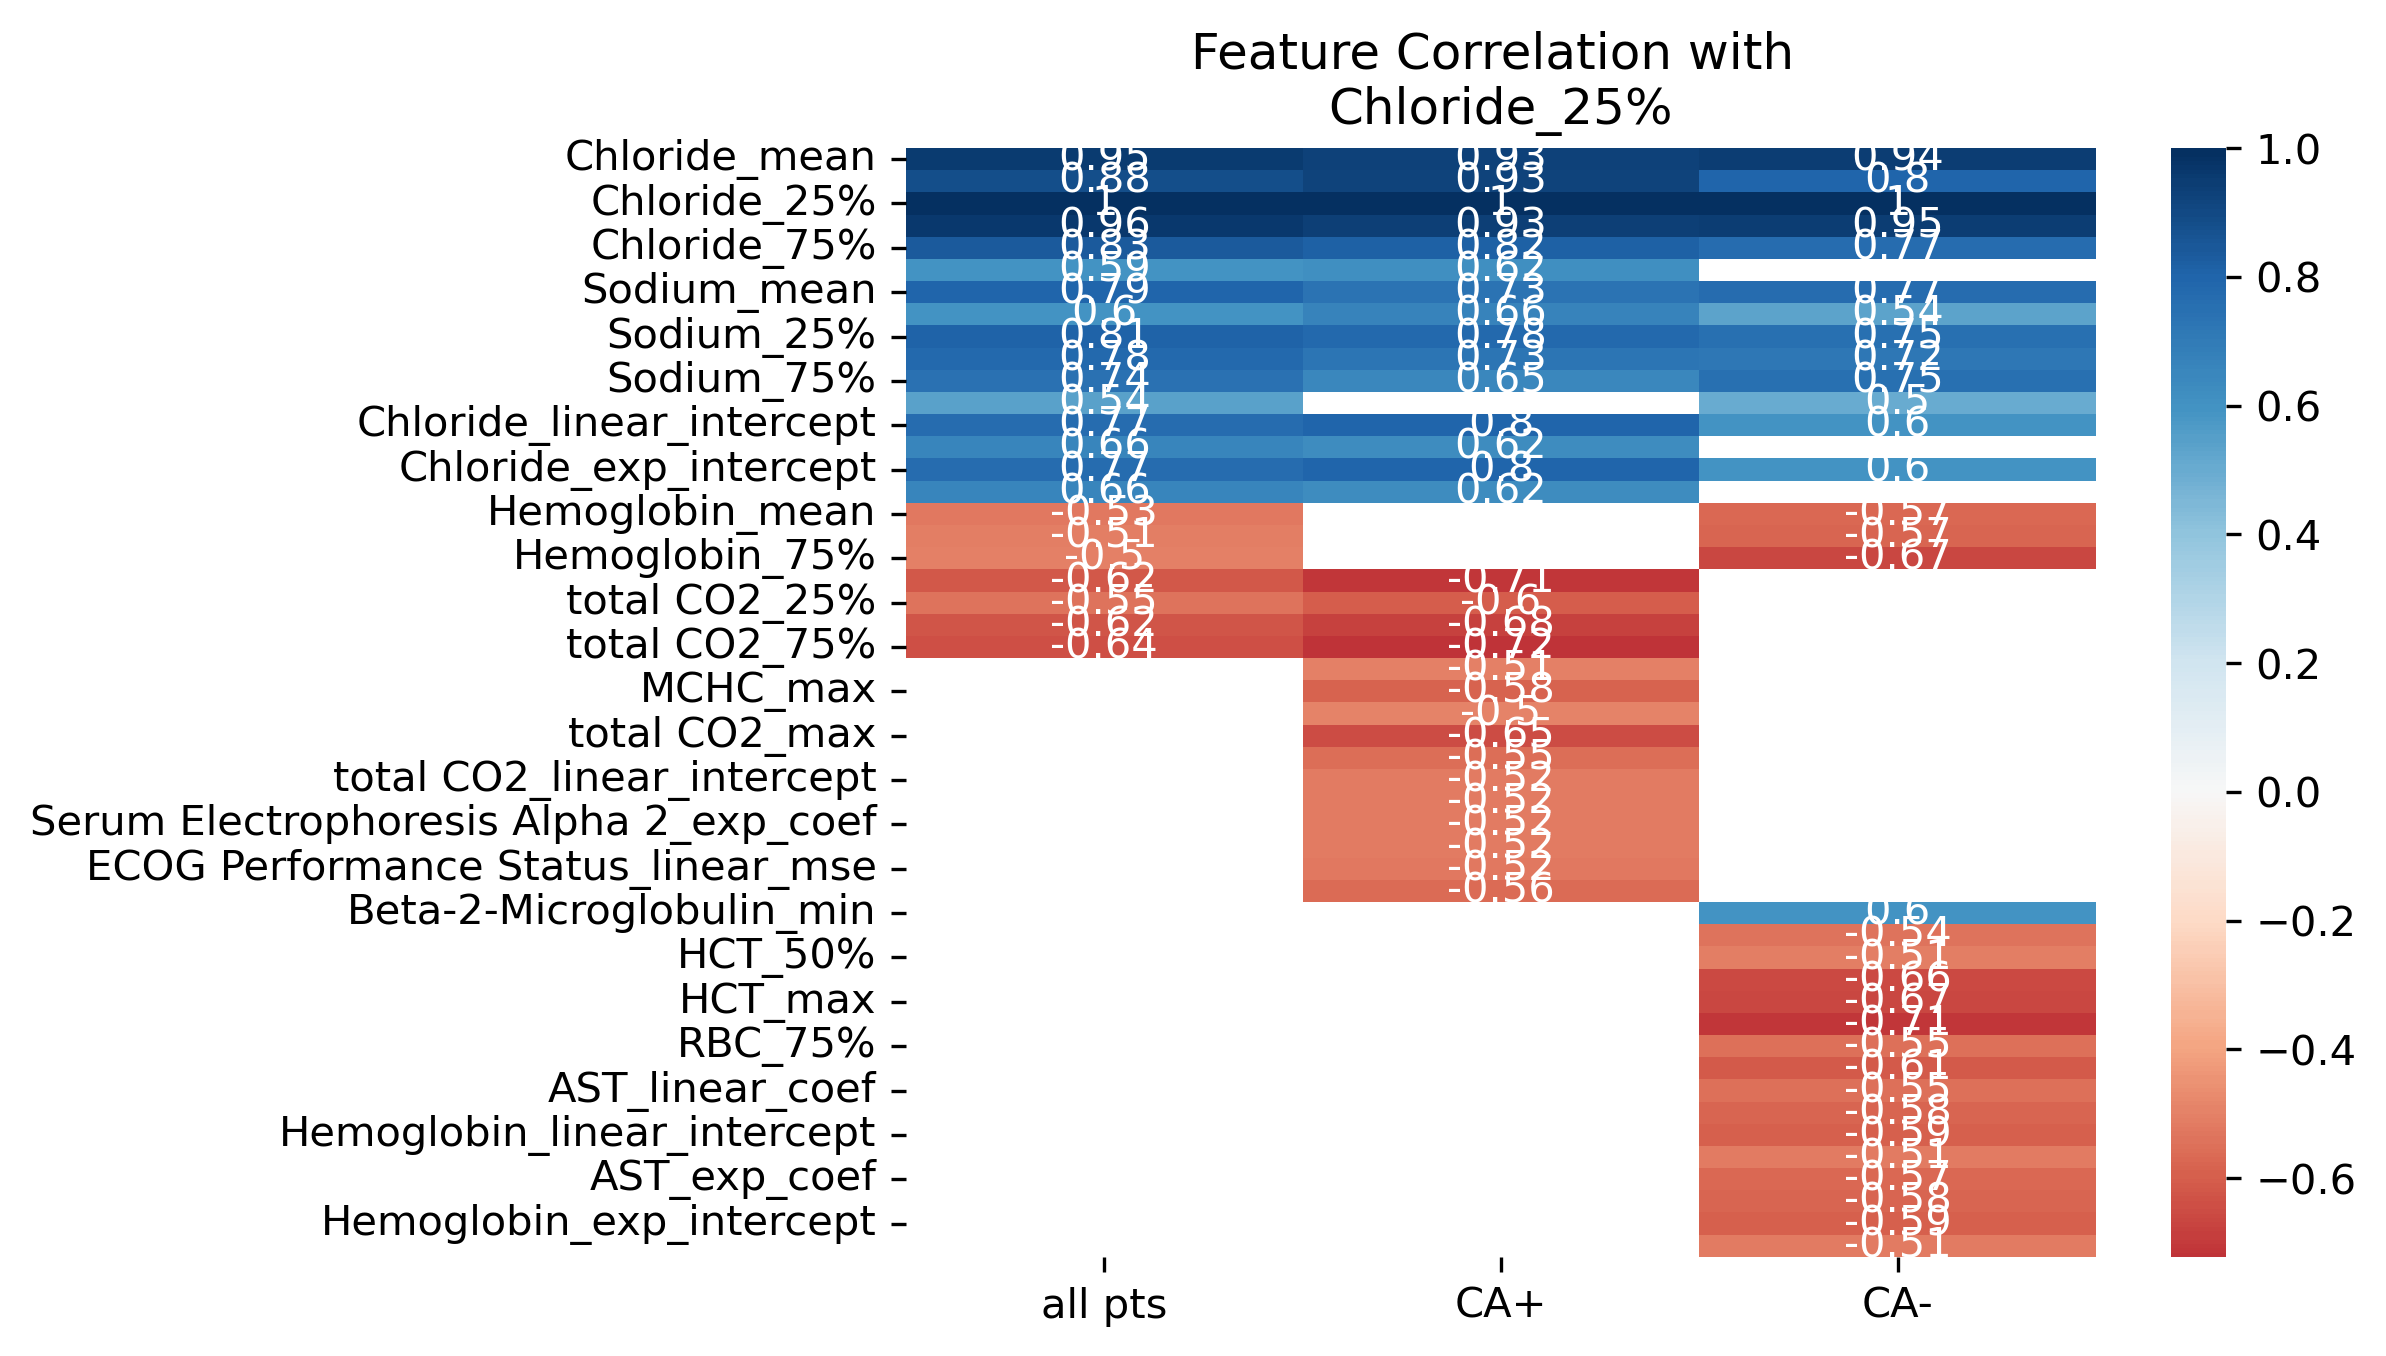

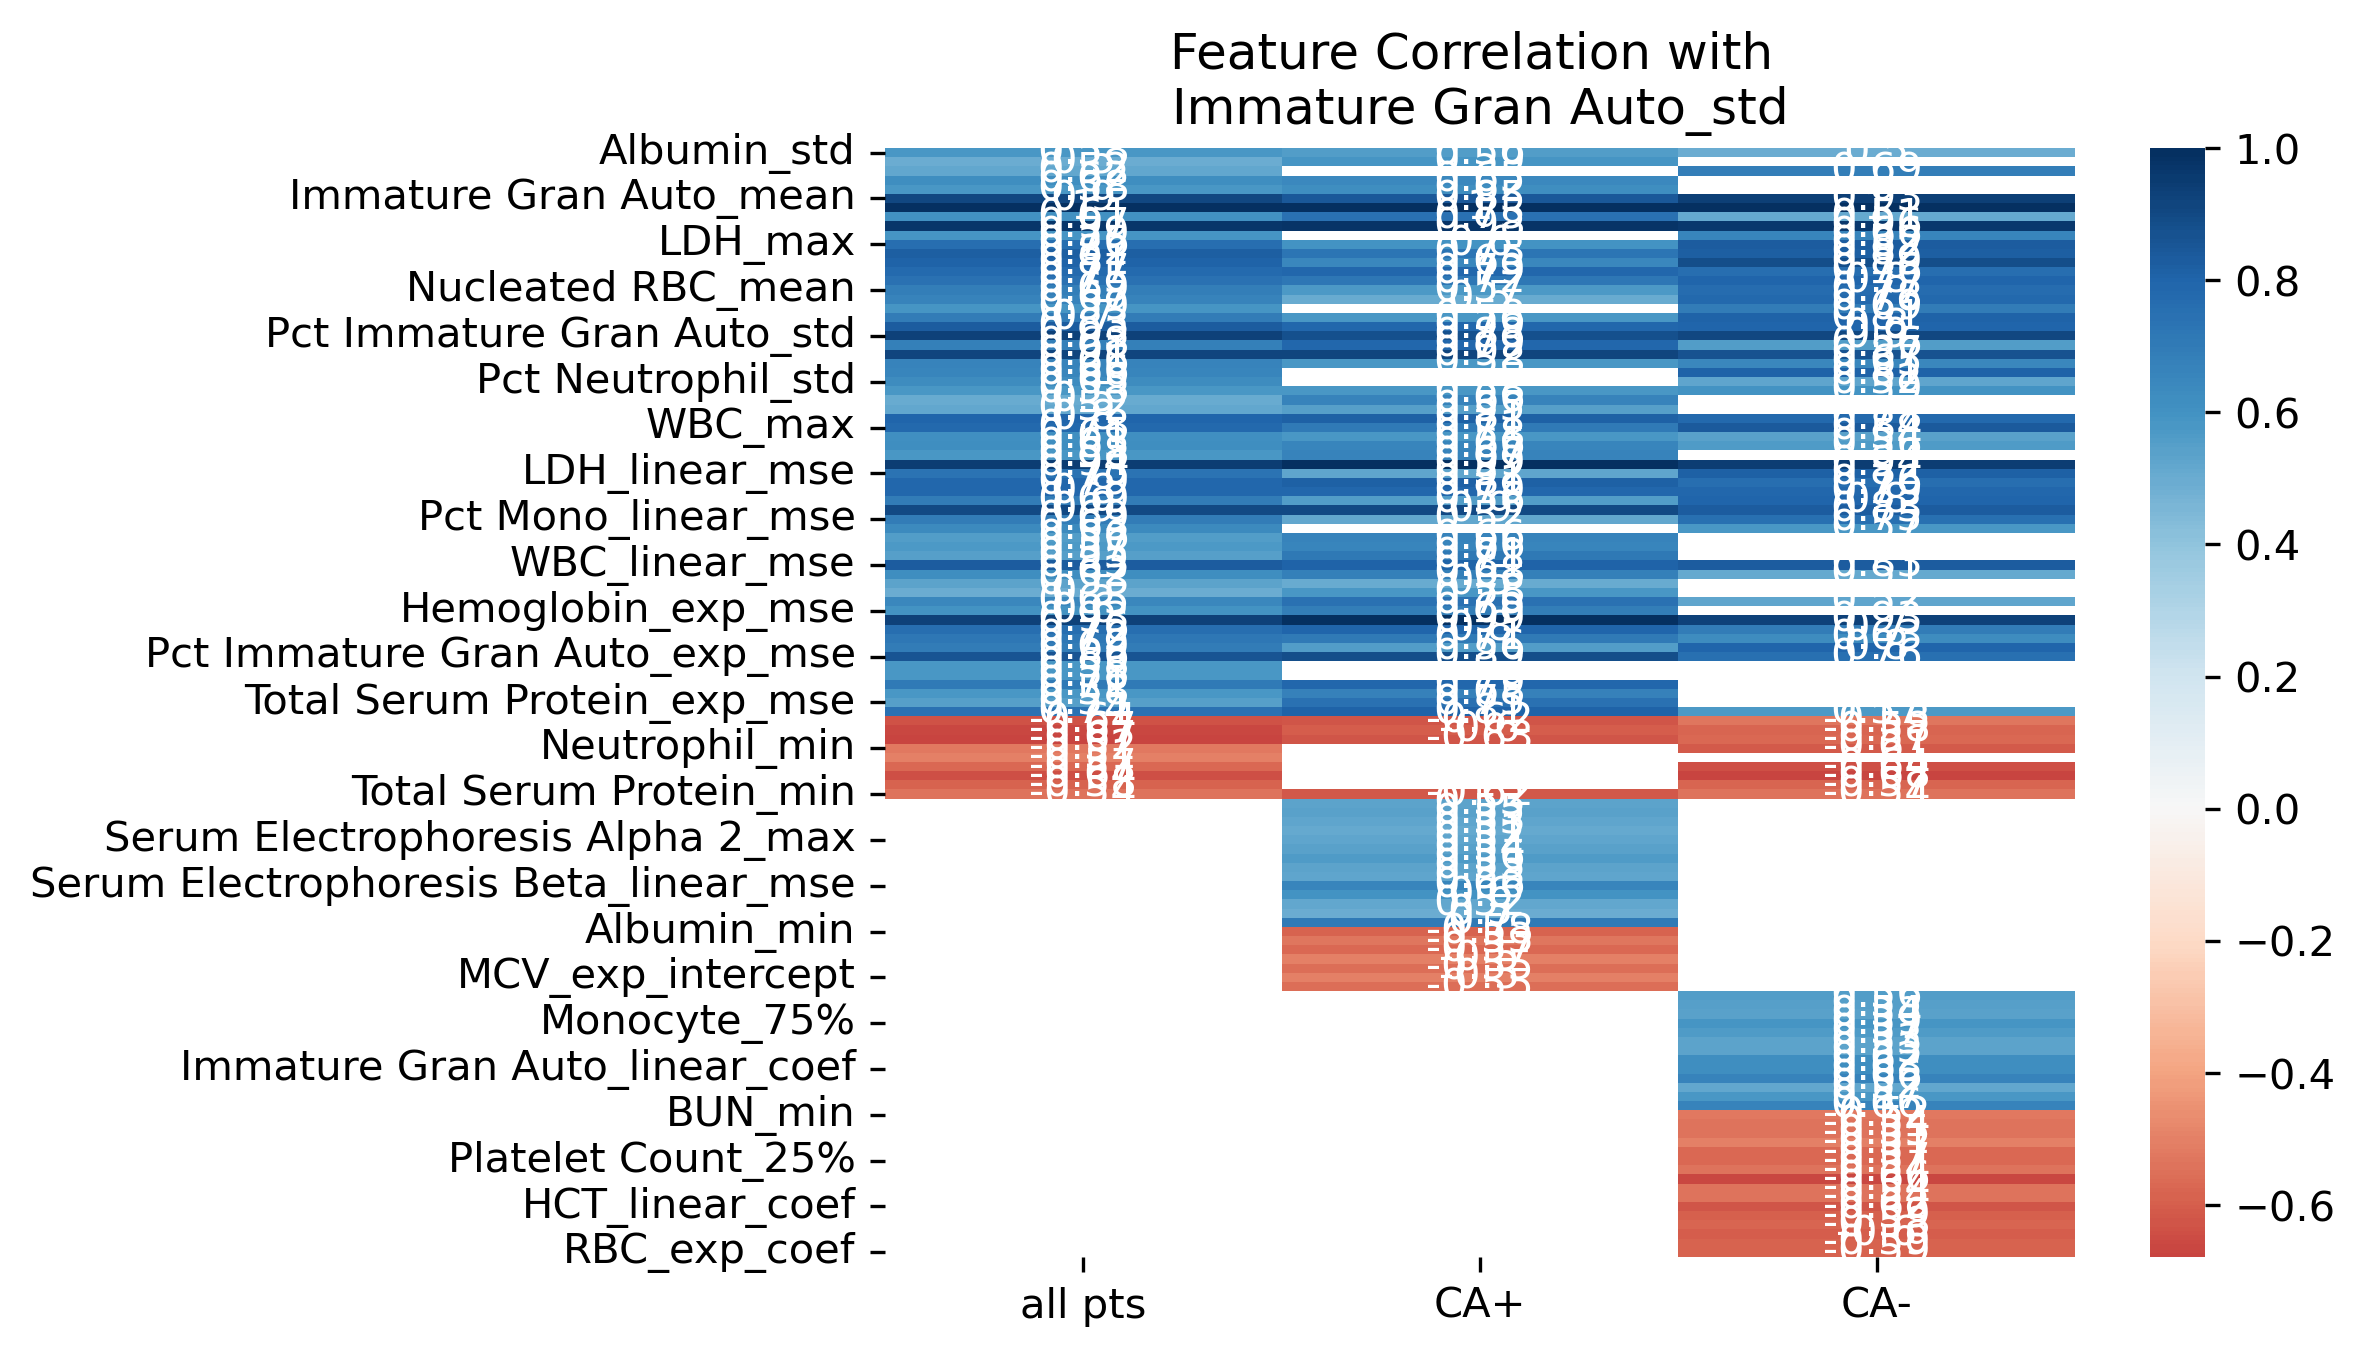

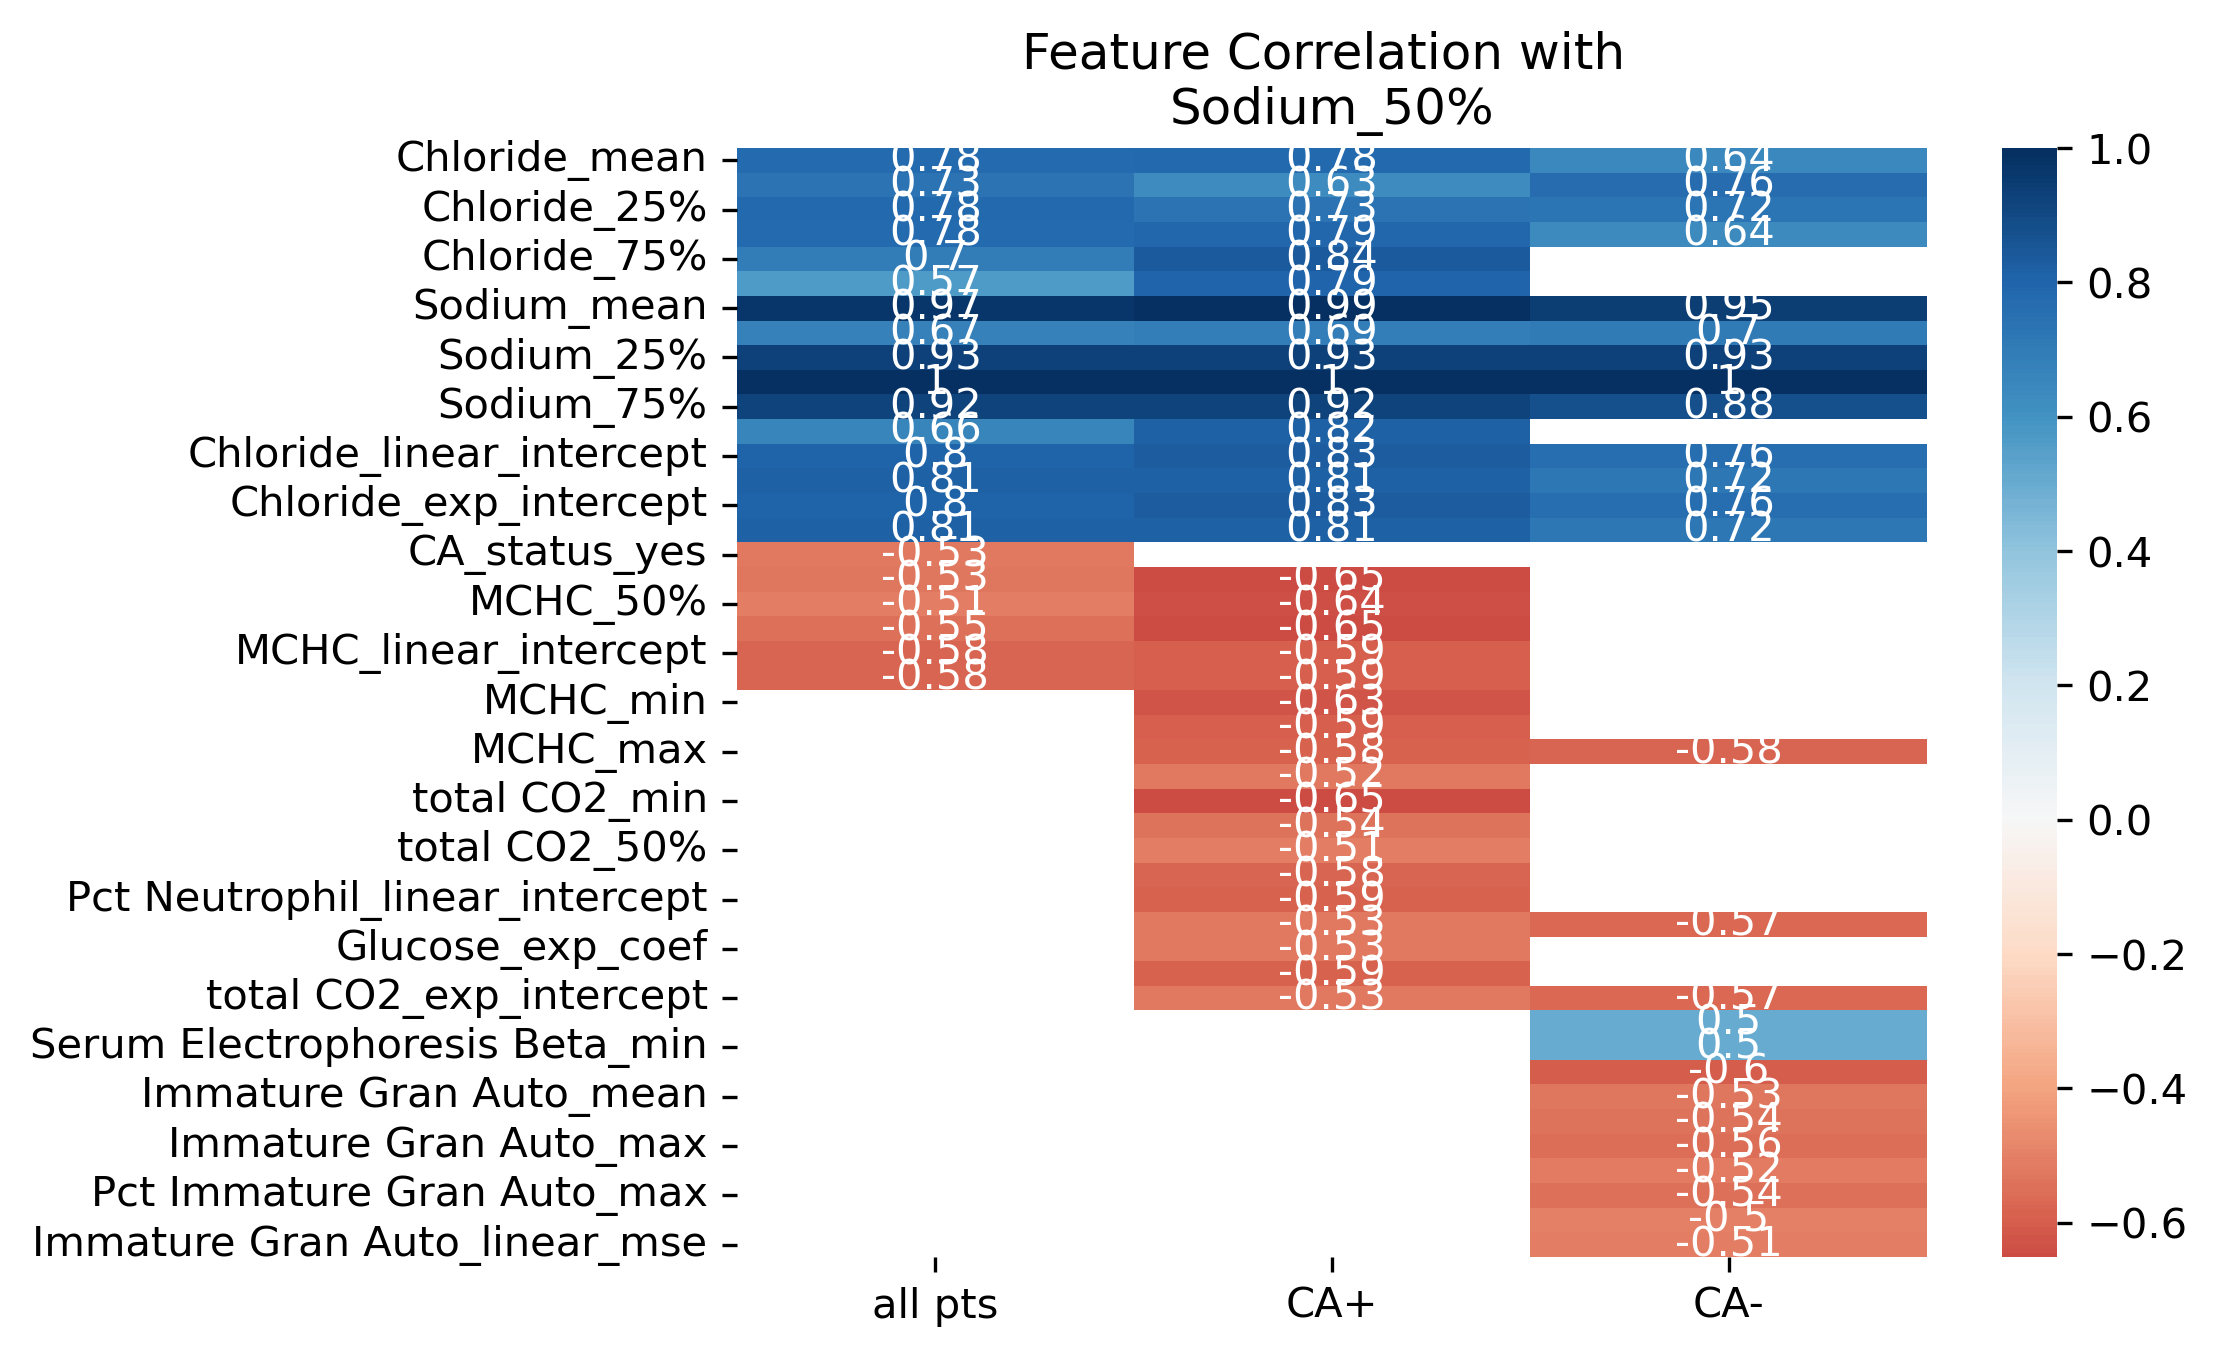

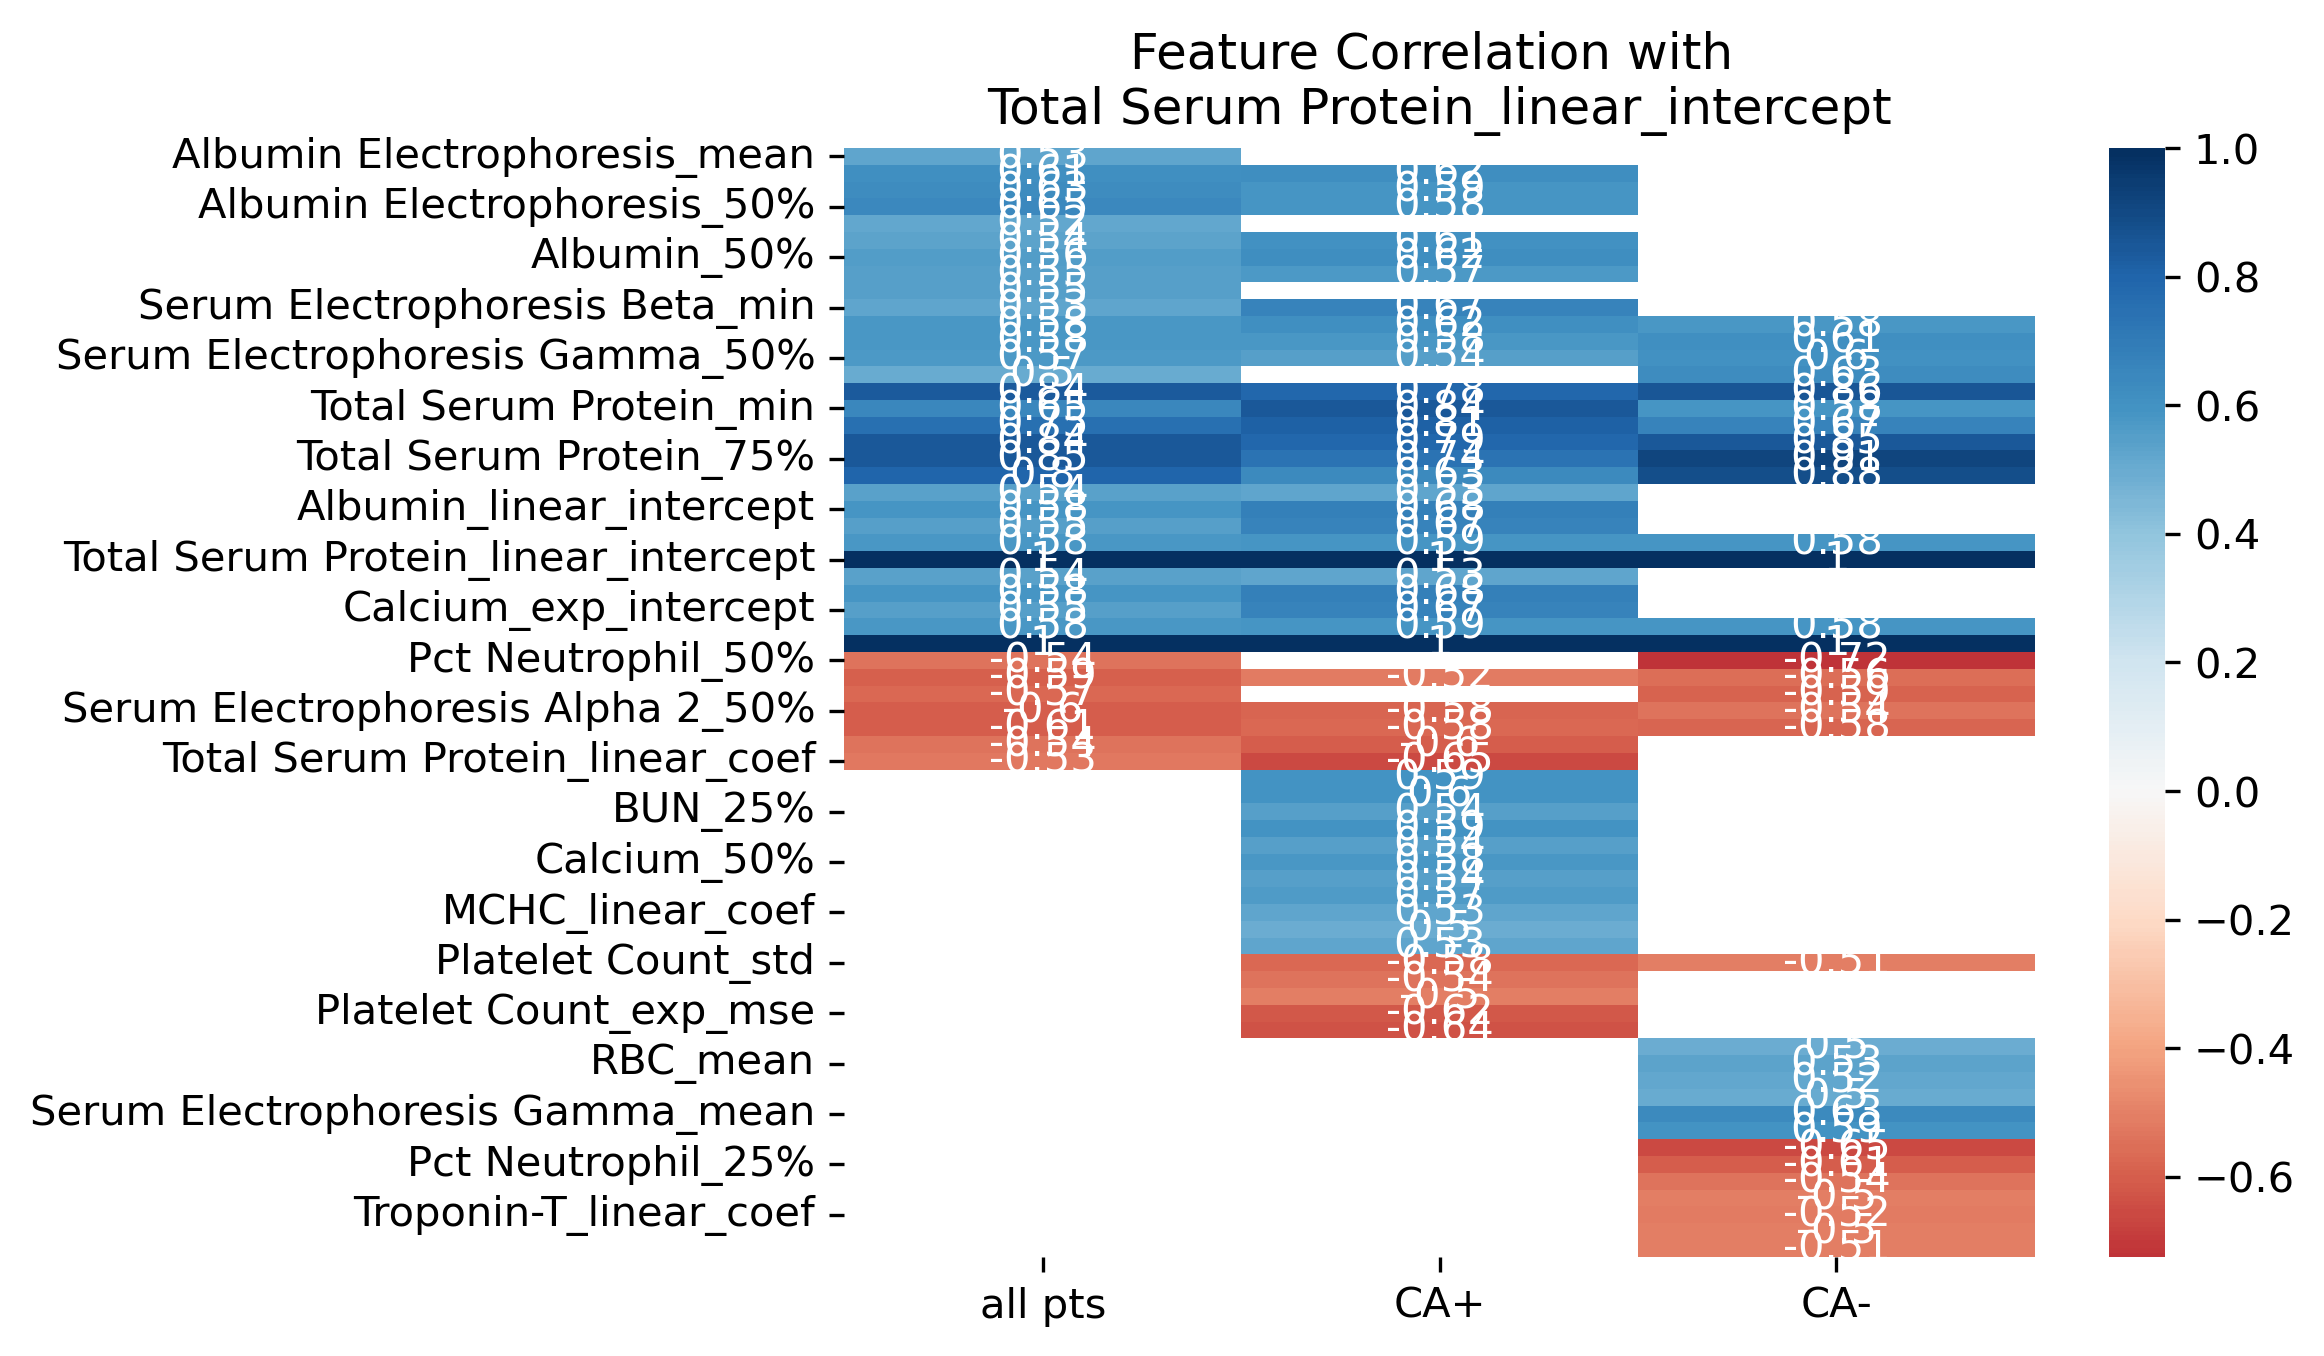

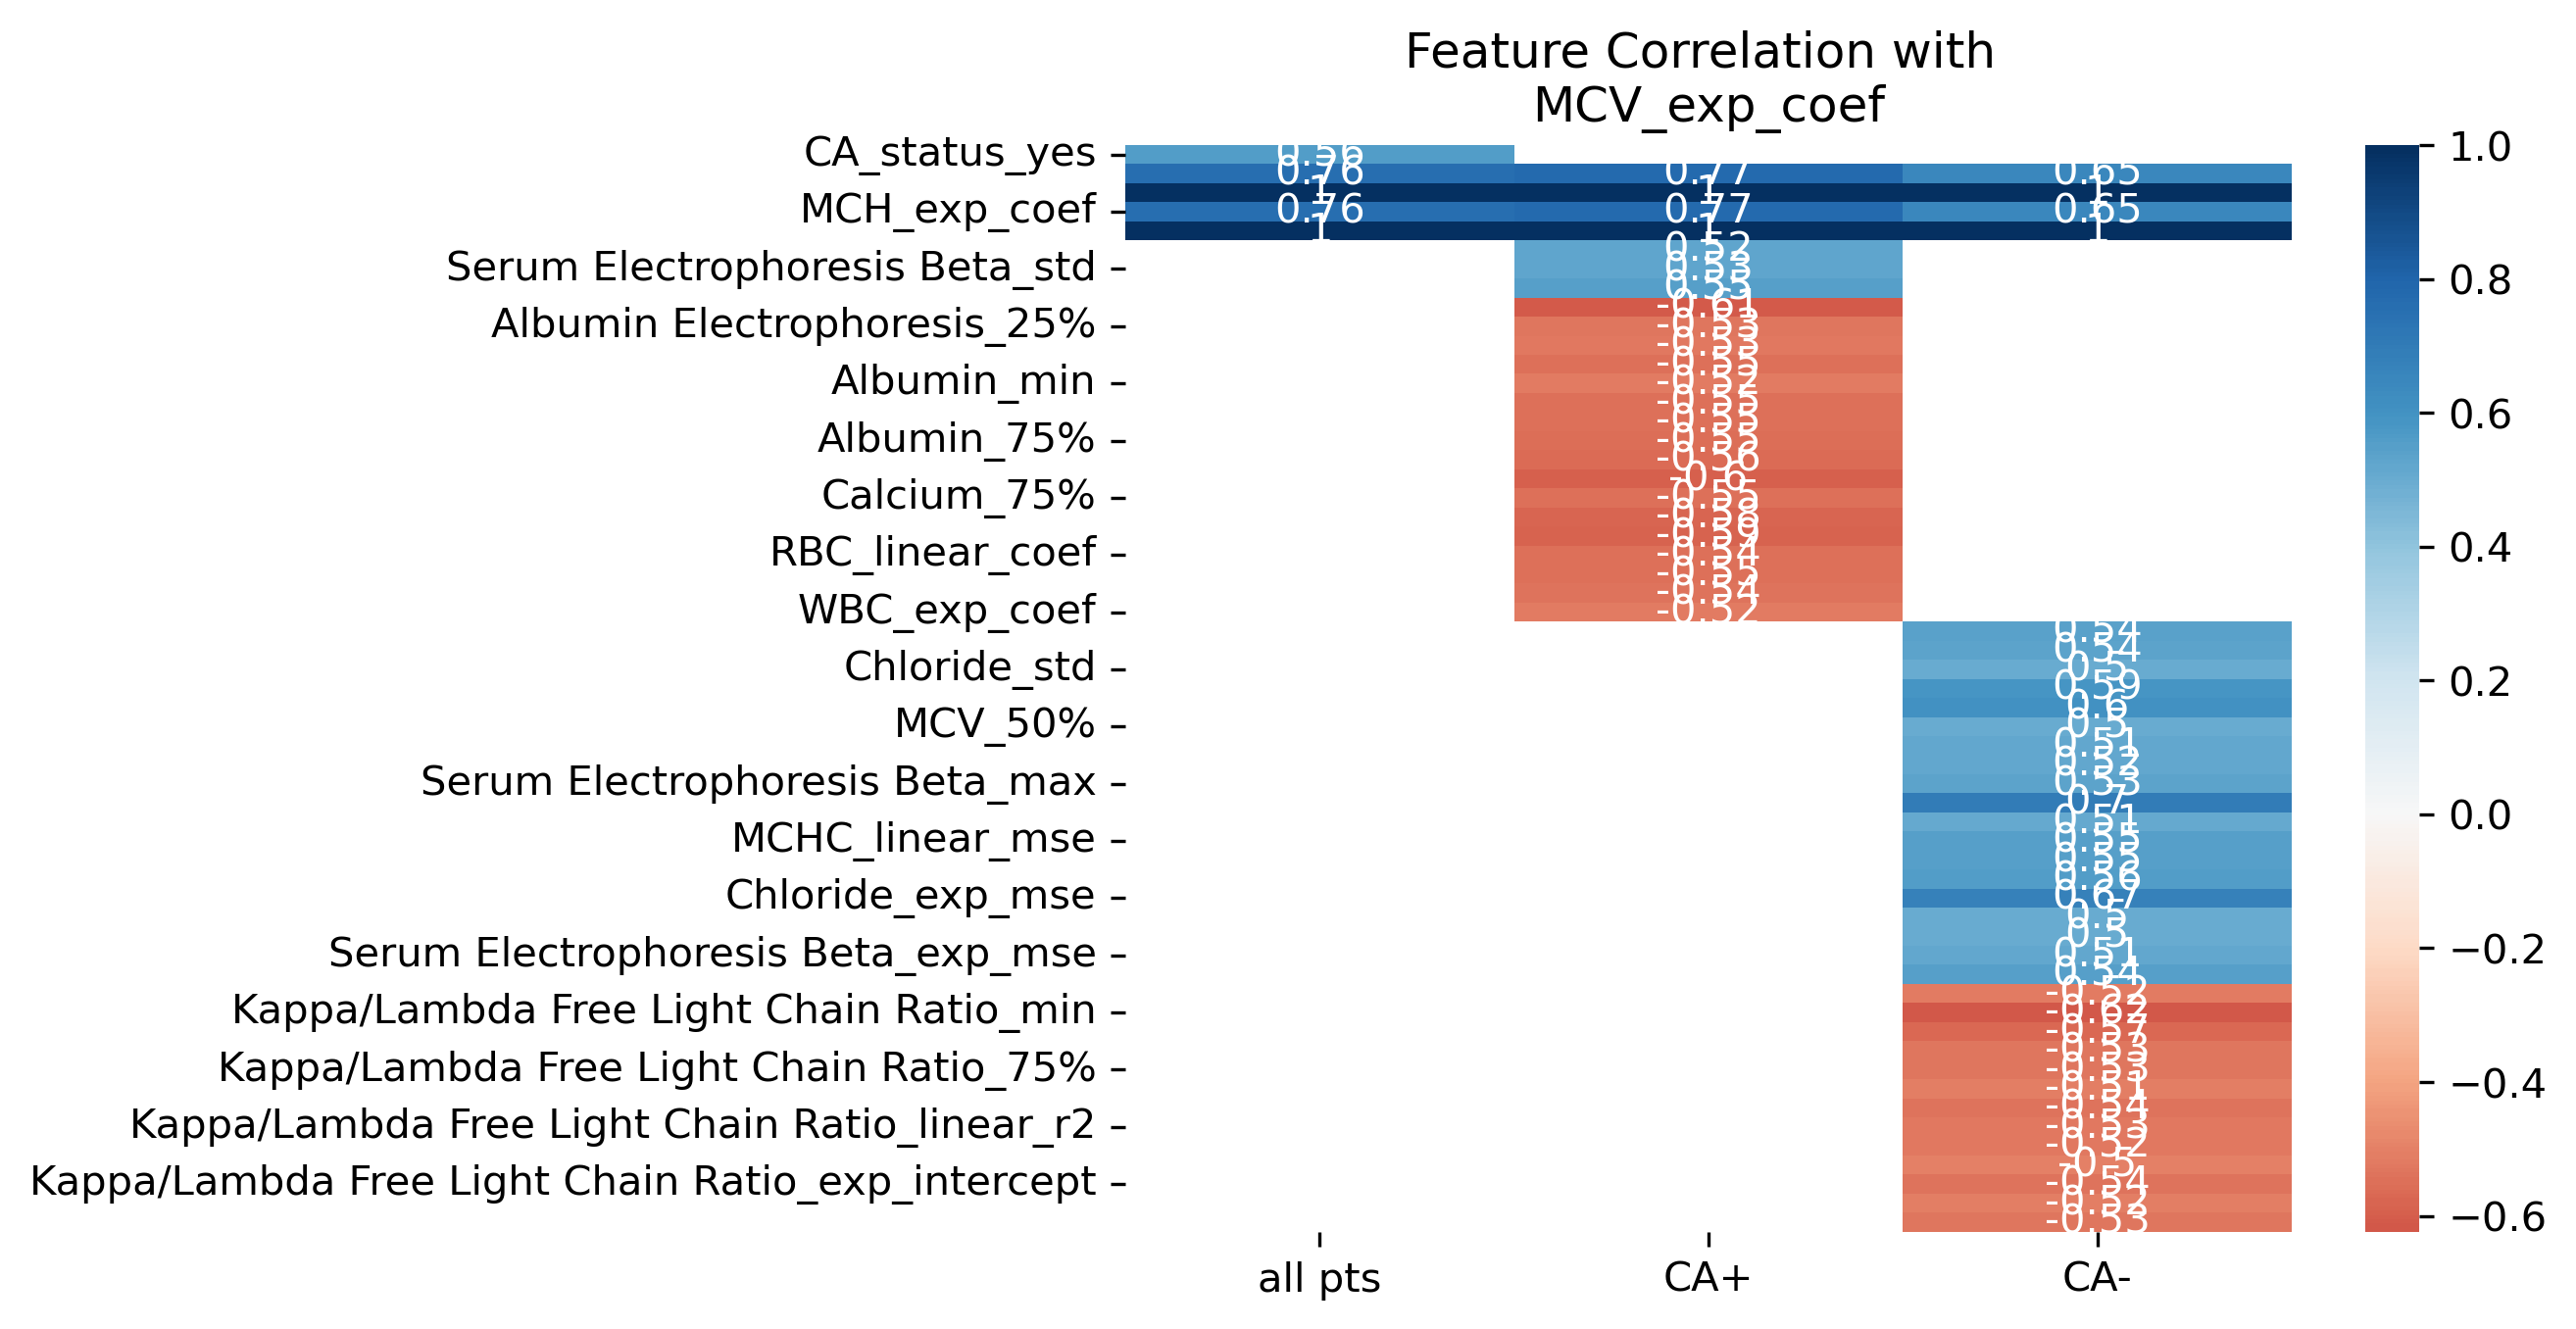

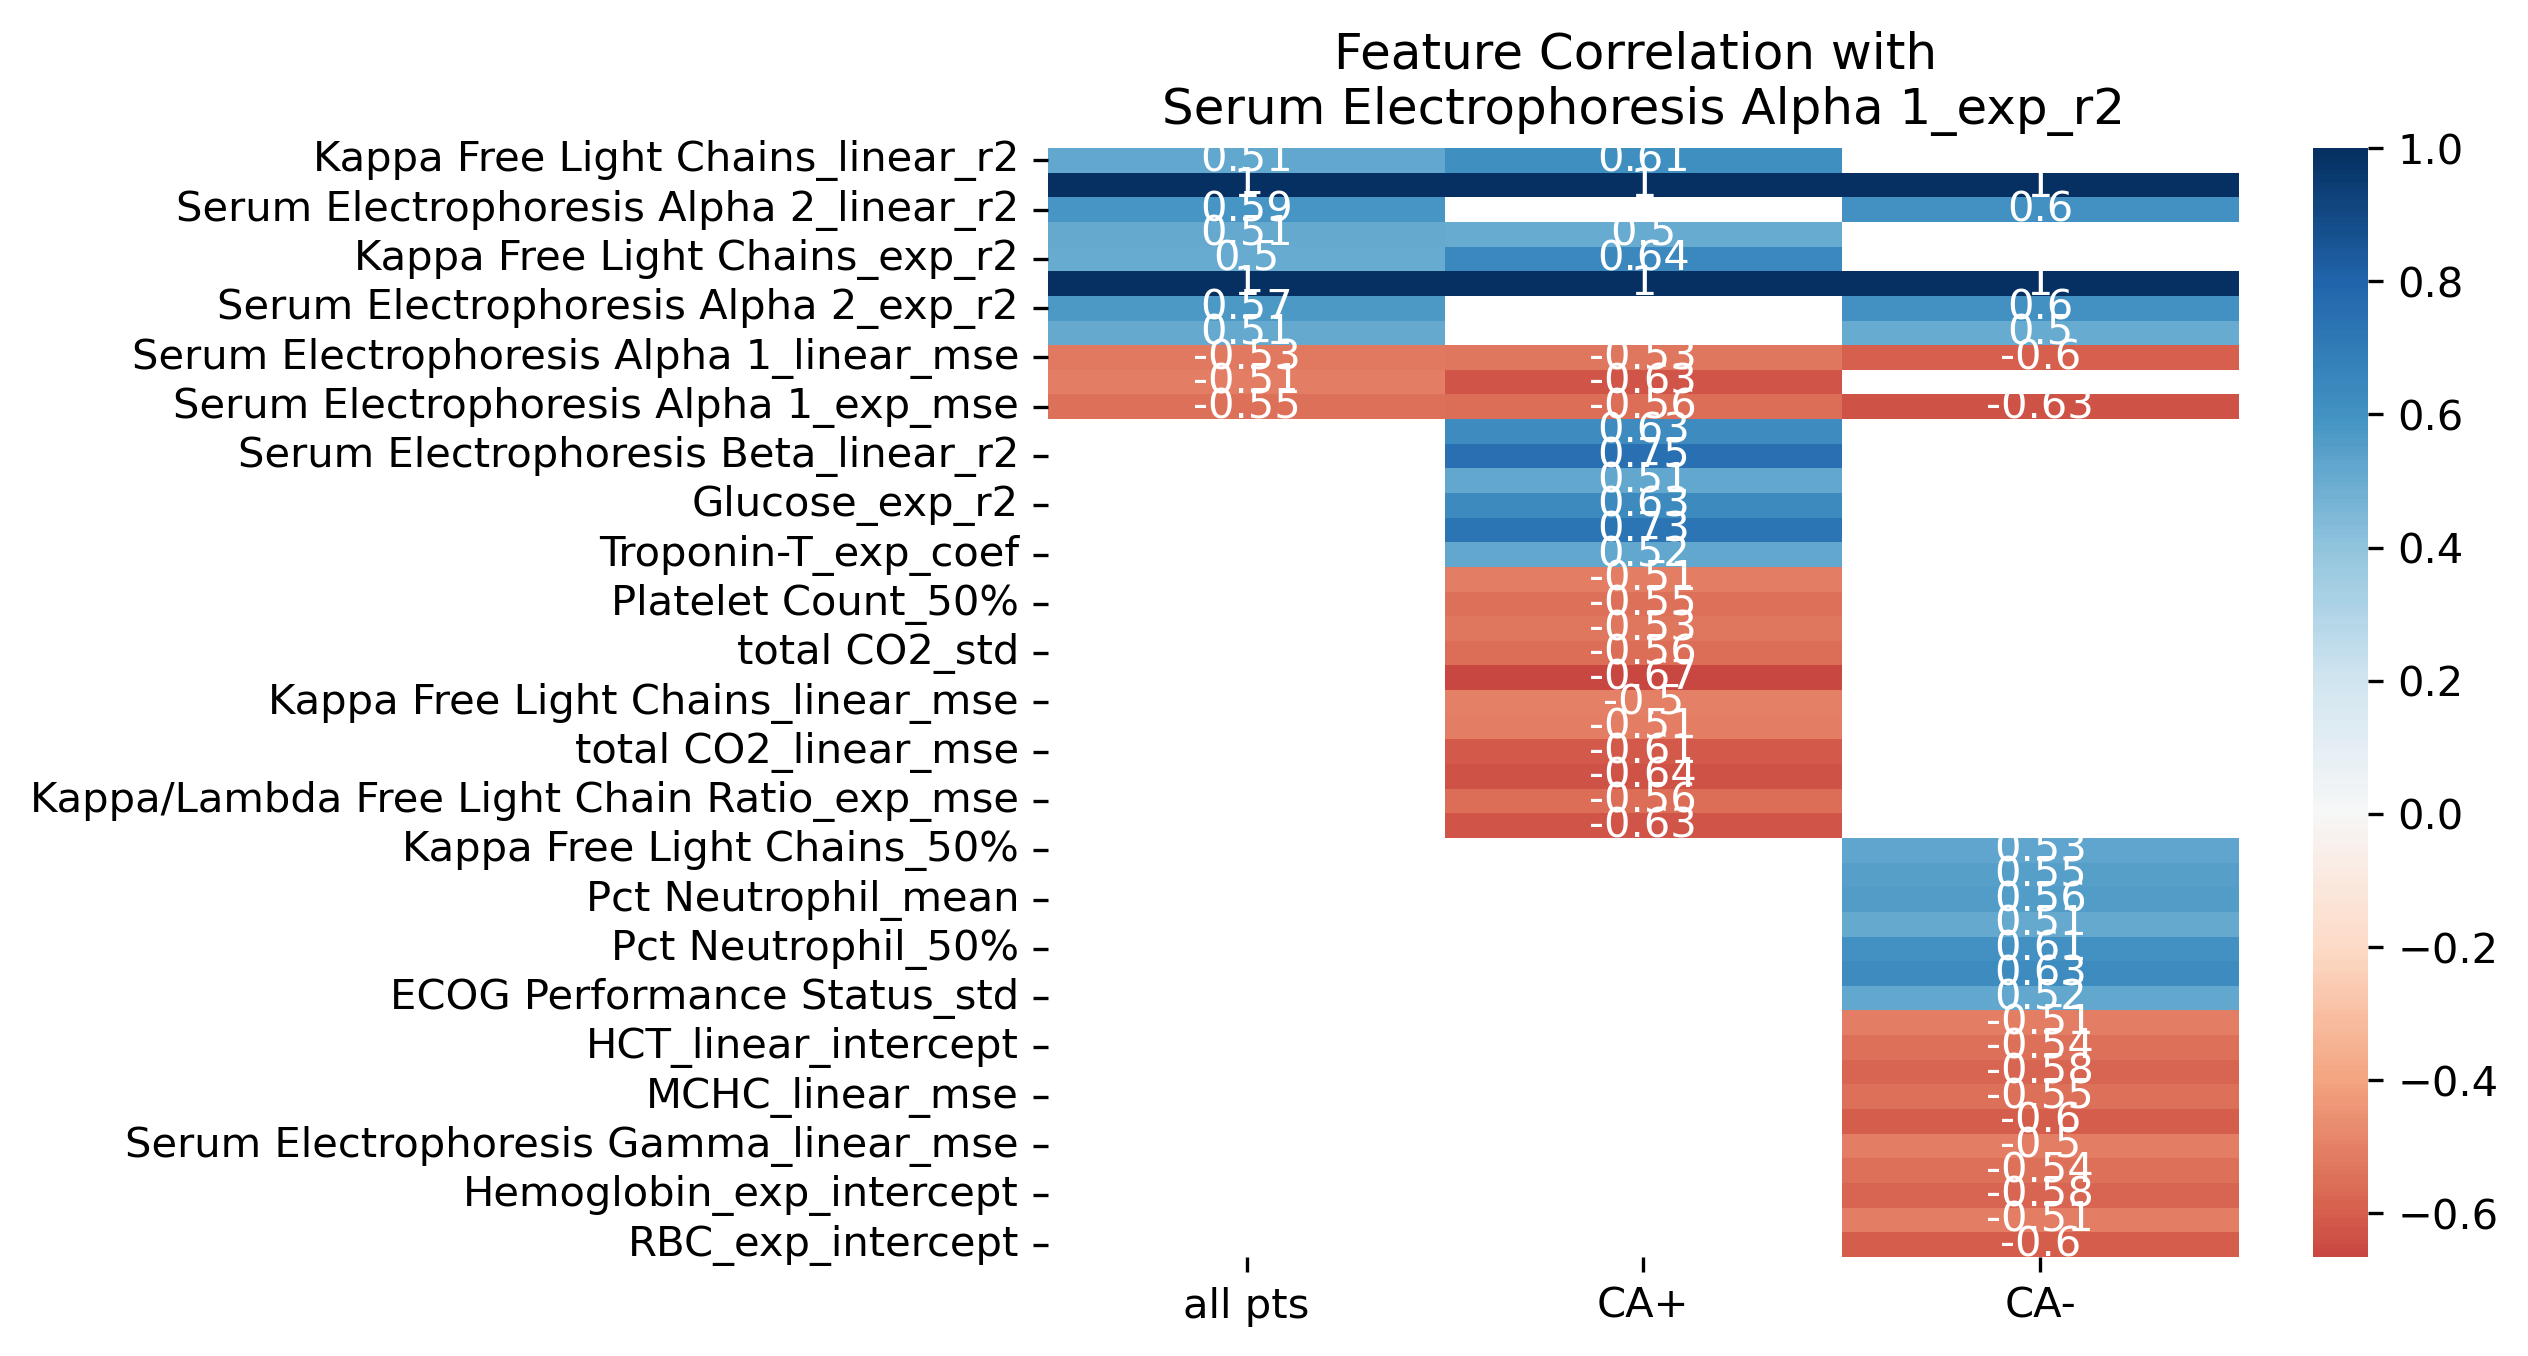

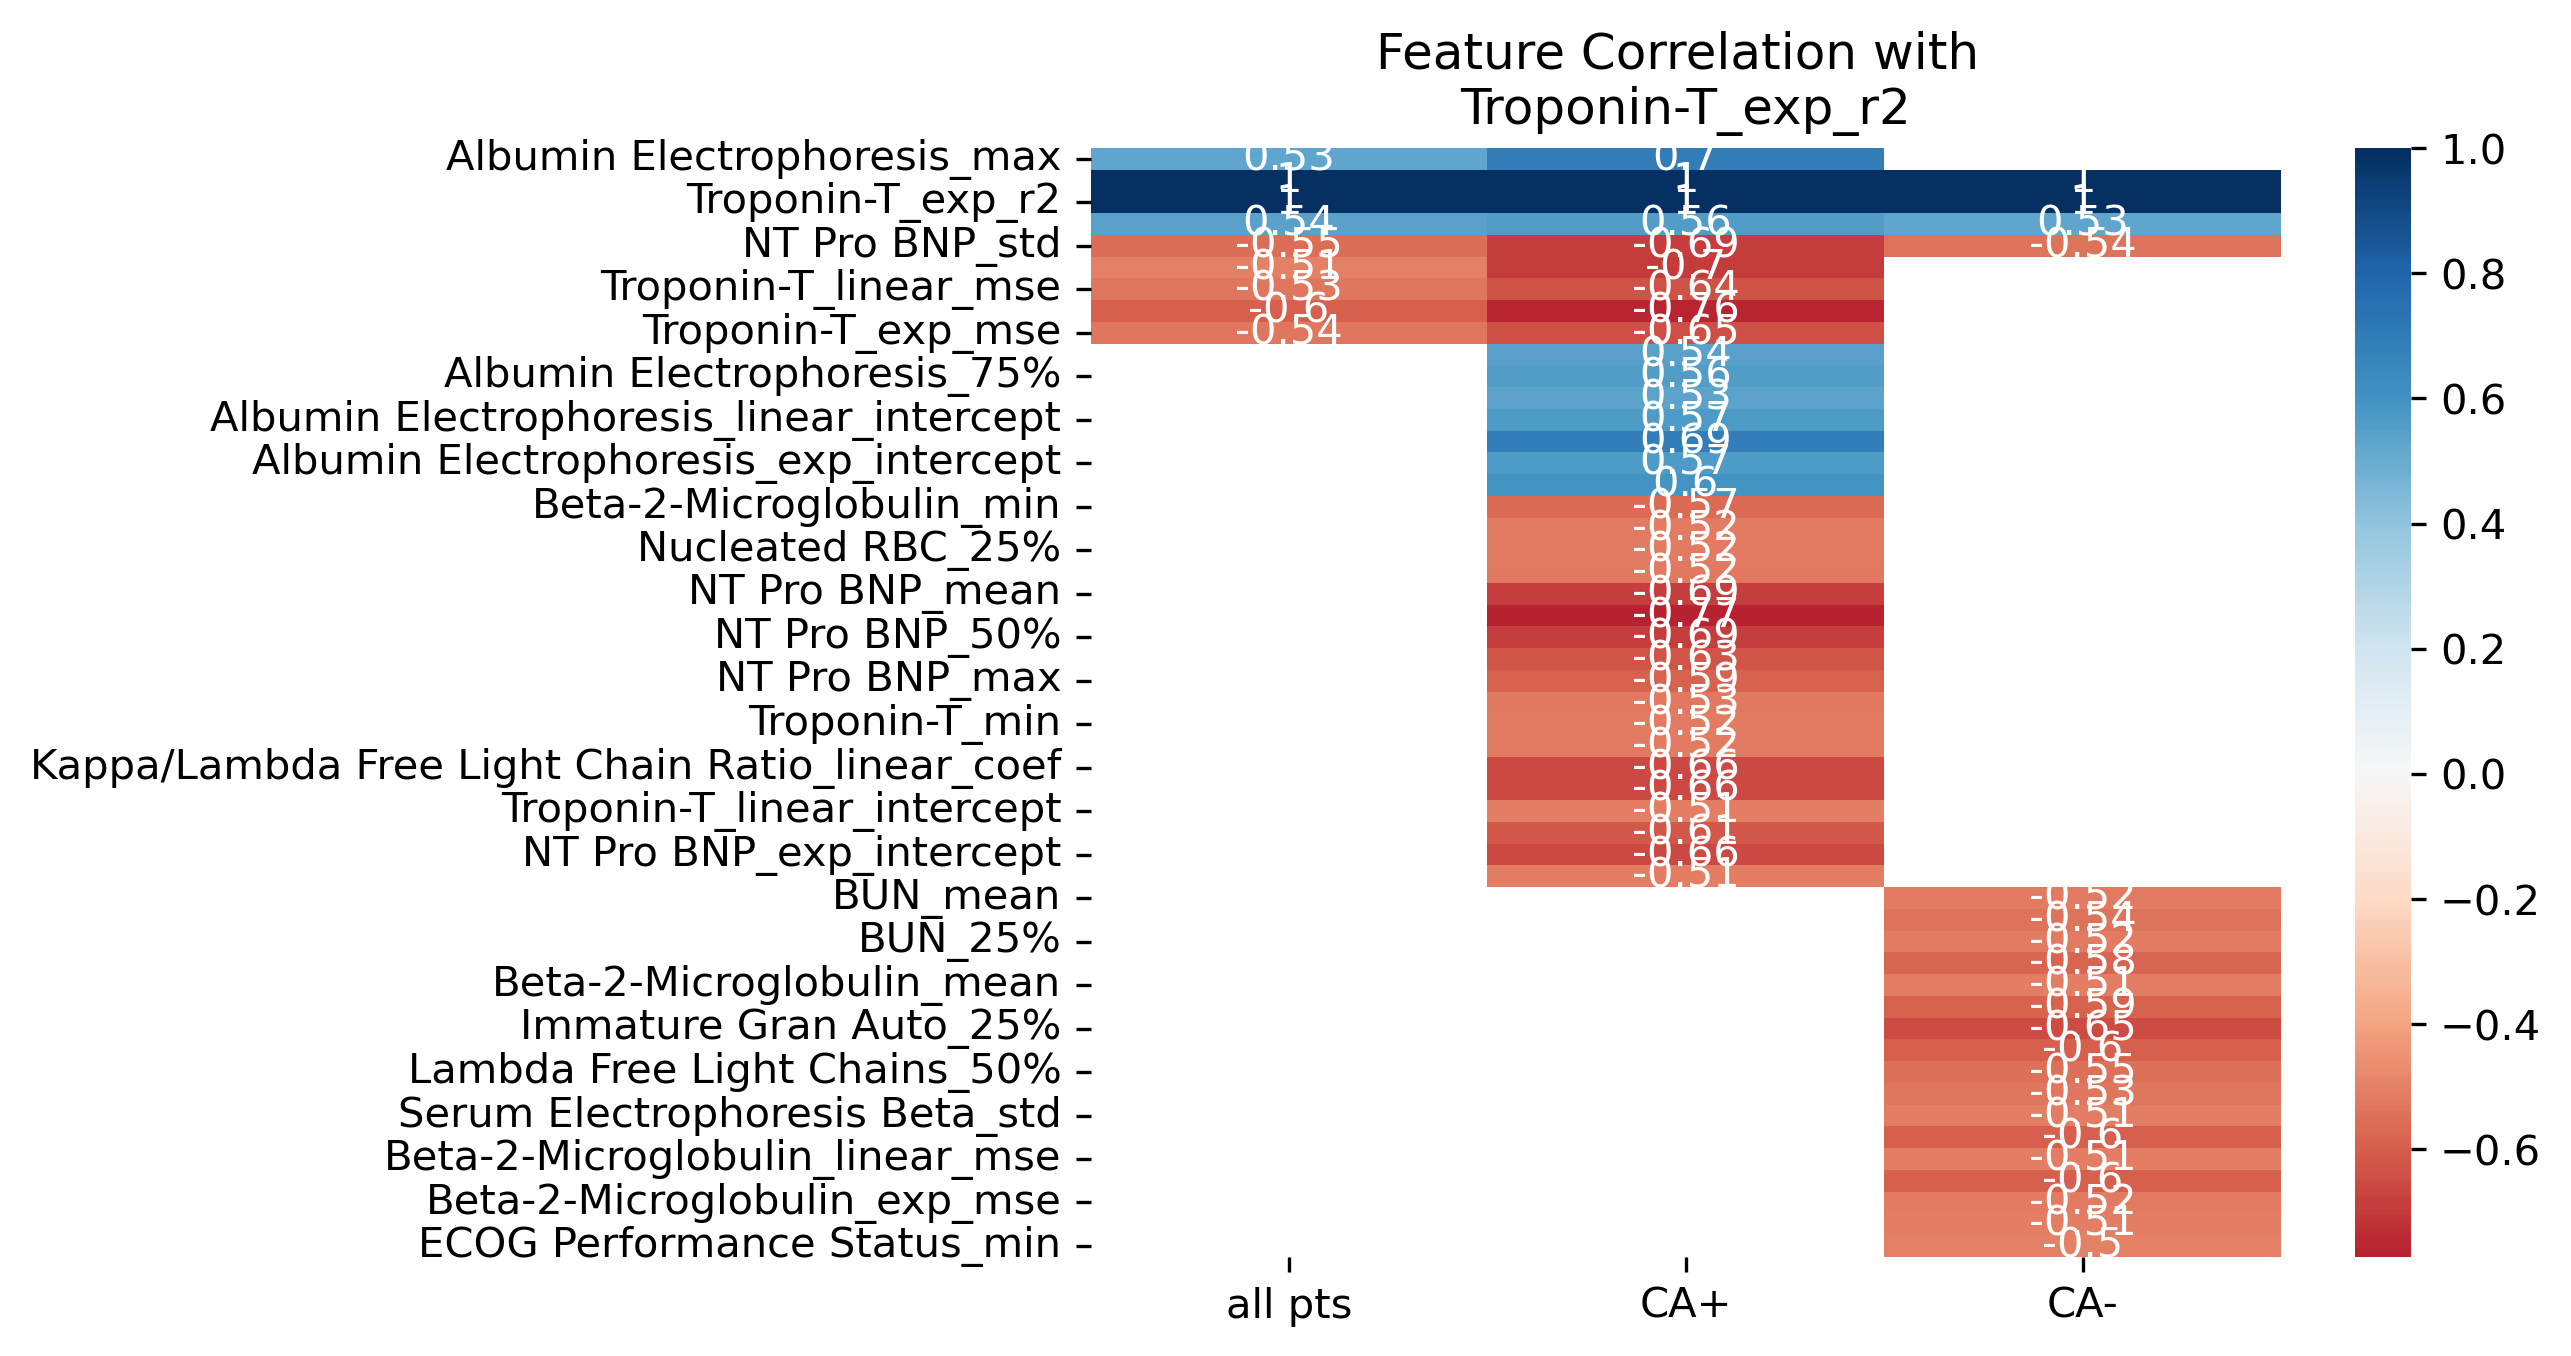

In [187]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= "descOnly_", fileName_suffix= "250410_v2",
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots()
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')